In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mne
import pickle
from pathlib import Path

In [2]:
path = Path('../data/asd/raw')
freqs = np.linspace(4, 12, 41)

info = pd.read_csv(path / 'path_file.csv')
info['fn'] = info['fn'].str.replace('и' + chr(774), 'й') # For some reason, filenames encode й as 2 unicode characters
info = info.groupby("fn").filter(lambda x: len(x) == 1)
info.reset_index(drop=True, inplace=True)
typical = np.where(info['target'] == 'typical')[0]
asd = np.where(info['target'] == 'asd')[0]

eegs = {i: mne.io.read_raw_fif(path / fn, verbose=False) for i, fn in info['fn'].items()}
ch_names = eegs[0].ch_names

assert np.all([eegs[i].info['sfreq'] == sfreq for i, sfreq in info['sfreq'].items()])
info

fn   target dataset_name  sfreq  \
0      sedrykyn_sasha_7_og_concat_19.raw.fif      asd          asd    125   
1       roma gritchin _5_fon_open_19.raw.fif      asd          asd    125   
2                 boy5_asd_og_new_19.raw.fif      asd          asd    125   
3    viflyancev_4_asd_fon__concat_19.raw.fif      asd          asd    125   
4         andrey_matveev3_asd_new_19.raw.fif      asd          asd    125   
..                                       ...      ...          ...    ...   
322            artem_sarkis_6_fon_19.raw.fif  typical      typical    125   
323               gusarova_9_norm_19.raw.fif  typical      typical    125   
324     акулов миша 10 от даши_ог_19.raw.fif  typical      typical    125   
325                      жавнис_3_19.raw.fif  typical      typical    125   
326           никита 7 от даши_ог_19.raw.fif  typical      typical    125   

     age  seconds  
0      7     47.0  
1      5     33.0  
2      5     50.0  
3      4     58.0  
4      3     50.0  
..   ...      ...  
322    6     44.0  
323    9     83.0  
324   10     42.0  
325    3    386.0  
326    7     57.0  

[327 rows x 6 columns]

In [3]:
import sys
sys.path.append('../')

from pipeline.features import get_merged_df
from sklearn.metrics import roc_auc_score

ModuleNotFoundError: No module named 'sklearn'

In [4]:
features_path = Path('../data/asd/features')
feature_methods = [
    'env-alpha',
    'env-beta',
    'coh-alpha',
    'coh-beta',
    'bands',
]

age_groups = {'2-4': range(2, 5),
              '5-6': range(5, 7),
              '7-9': range(7, 10),
              '10+': range(10, 20)}

In [5]:
data = get_merged_df(features_path / 'all_0_0_20', feature_methods)
features = list(data.columns.difference(['fn', 'target']))
data['target'] = data['target'] == 'asd'
data = data.join(info[['fn', 'age']].set_index('fn'), on='fn')
data

env_alpha_Fp1_Fp2  env_alpha_Fp1_F7  env_alpha_Fp1_F3  env_alpha_Fp1_Fz  \
0             0.894301          0.524368          0.817223          0.711028   
1             0.134027          0.461620          0.472063          0.882474   
2             0.389974          0.679241          0.912563          0.994476   
3             0.597099          0.348386          0.460732          0.398180   
4             0.232039          0.593211          0.530407          0.427668   
..                 ...               ...               ...               ...   
322           0.295342          0.680750          0.506854          0.665349   
323           0.063303          0.880142          0.943654          0.677545   
324           0.589293          0.425642          0.641269          0.647030   
325           0.547833          0.671194          0.671658          0.746955   
326           0.353539          0.701237          0.581034          0.363764   

     env_alpha_Fp1_F4  env_alpha_Fp1_F8  env_alpha_Fp1_T3  env_alpha_Fp1_C3  \
0            0.534992          0.641244          0.451378          0.413385   
1            0.140260          0.128484          0.300010          0.320836   
2            0.138644          0.210552          0.158212         -0.060223   
3           -0.182316          0.091121          0.213839          0.318115   
4           -0.026946          0.044114          0.298576          0.234543   
..                ...               ...               ...               ...   
322          0.355128          0.306866          0.164497          0.245771   
323          0.024405          0.137327          0.682872          0.417101   
324          0.332940          0.283482          0.354599          0.235146   
325          0.340495          0.246346          0.212733          0.142256   
326          0.240924          0.279541          0.188904          0.124152   

     env_alpha_Fp1_Cz  env_alpha_Fp1_C4  ...  bands_beta_Pz  bands_alpha_P4  \
0            0.353105          0.307792  ...       0.107455        0.134028   
1            0.082824          0.141817  ...       0.185615        0.160787   
2            0.012387         -0.005151  ...       0.099079        0.086513   
3           -0.048845         -0.050269  ...       0.055385        0.081833   
4            0.029659         -0.007099  ...       0.217407        0.105205   
..                ...               ...  ...            ...             ...   
322          0.117259          0.222935  ...       0.117509        0.175355   
323          0.600765          0.008430  ...       0.124859        0.356744   
324          0.264547          0.372298  ...       0.226413        0.117956   
325          0.081973          0.176395  ...       0.071533        0.140900   
326          0.058210         -0.042883  ...       0.163567        0.093547   

     bands_beta_P4  bands_alpha_T6  bands_beta_T6  bands_alpha_O1  \
0         0.098581        0.148476       0.118601        0.172558   
1         0.145909        0.092589       0.234765        0.134004   
2         0.133634        0.092880       0.206056        0.077225   
3         0.084228        0.083396       0.150227        0.080598   
4         0.235625        0.106891       0.711488        0.161248   
..             ...             ...            ...             ...   
322       0.051322        0.165843       0.073415        0.054644   
323       0.125602        0.265229       0.140604        0.210175   
324       0.201347        0.132947       0.354662        0.131131   
325       0.084020        0.090539       0.125414        0.076485   
326       0.173807        0.080851       0.239925        0.111549   

     bands_beta_O1  bands_alpha_O2  bands_beta_O2  age  
0         0.115668        0.137518       0.103735    7  
1         0.196179        0.126407       0.191845    5  
2         0.275413        0.068992       0.146905    5  
3         0.166482        0.091104       0.139684    4  
4         0.575508        0.1683

In [6]:
data_val = get_merged_df(features_path / 'val_0_20_40', feature_methods)
data_val = data_val[info['seconds'] >= 40]
data_val['target'] = data_val['target'] == 'asd'
data_val = data_val.join(info[['fn', 'age']].set_index('fn'), on='fn')

In [7]:
with open('selected_features.pickle', 'rb') as f:
    selected_features = pickle.load(f)

scores_df = pd.read_csv('ASD feature selection scores.csv', index_col=['Unnamed: 0', 'Unnamed: 1'], sep=';')
best_models = scores_df['roc-auc mean'].groupby(level=0).idxmax()
best_features = {key: selected_features[key] for key in best_models.values}
best_models

10+     (10+, LR)
2-4     (2-4, LR)
5-6    (5-6, XGB)
7-9     (7-9, RF)
Name: roc-auc mean, dtype: object

In [9]:
def get_corr(ag_name):
    features = set(flatten(selected_features[best_models[ag_name]]))
    corr_matrix = data.loc[data['age'].isin(age_groups[ag_name]), features] \
                  .copy() \
                  .reset_index(drop=True) \
                  .corr() \
                  .fillna(0)
    np.fill_diagonal(corr_matrix.values, 1)
    return corr_matrix
            #    .dropna(how='all', axis=0) \
            #    .dropna(how='all', axis=1)

def flatten(lst: list[list]) -> list:
    flat = []
    for lst_ in lst:
        flat.extend(lst_)
    return flat

In [9]:
from sklearn.cluster import AgglomerativeClustering

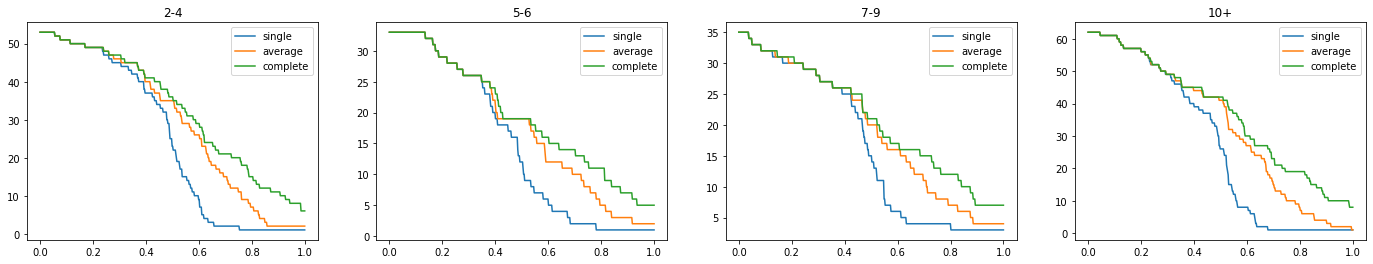

In [34]:
thresholds = np.linspace(0, 1, 500)

plt.figure(figsize=(24, 4))
for i, ag_name in enumerate(age_groups, 1):
    plt.subplot(1, 4, i).set_title(ag_name)
    for linkage in ('single', 'average', 'complete'):
        n_clusters = np.array([AgglomerativeClustering(n_clusters=None, affinity='precomputed', distance_threshold=t, linkage=linkage).fit(1 - get_corr(ag_name)).n_clusters_ for t in thresholds])
        plt.plot(thresholds, n_clusters, label=linkage)
    plt.legend()
plt.show()

In [44]:
clus = AgglomerativeClustering(n_clusters=None, affinity='precomputed', distance_threshold=0.6, linkage='average')
clusters = pd.DataFrame({ag_name: pd.Series(clus.fit_predict(1 - get_corr(ag_name)), index=get_corr(ag_name).columns) for ag_name in age_groups})

In [45]:
clusters.max()

2-4    25.0
5-6    11.0
7-9    15.0
10+    26.0
dtype: float64

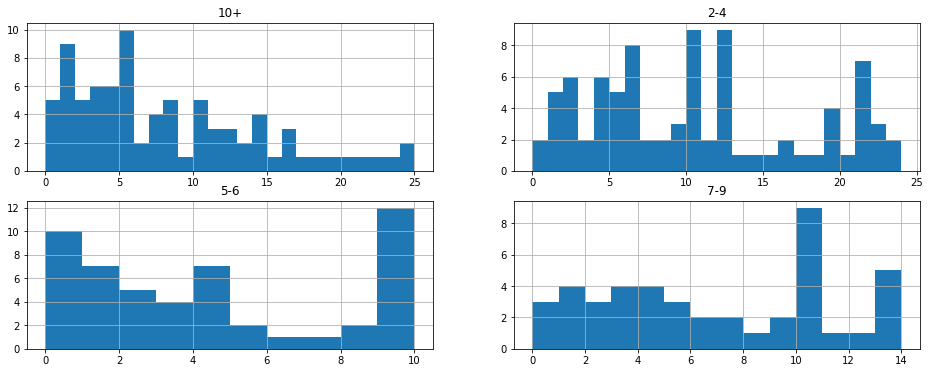

In [46]:
plt.figure(figsize=(16, 6))
i = 0
for ag_name, key in best_models.items():
    i += 1
    plt.subplot(2, 2, i).set_title(ag_name)
    clusters[ag_name][flatten(selected_features[key])].hist(bins=range(clusters[ag_name].max().astype(int)))

In [9]:
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage, dendrogram

def plot_dendrogram(ag_name, thershold=0.6):
    corr_matrix = get_corr(ag_name)
    dist_vector = squareform(1 - corr_matrix)
    l_aver = linkage(dist_vector, method='average')

    plt.figure(figsize=(10, 20))
    dendrogram(l_aver, labels=corr_matrix.columns, orientation='left', color_threshold=threshold, leaf_font_size=14)

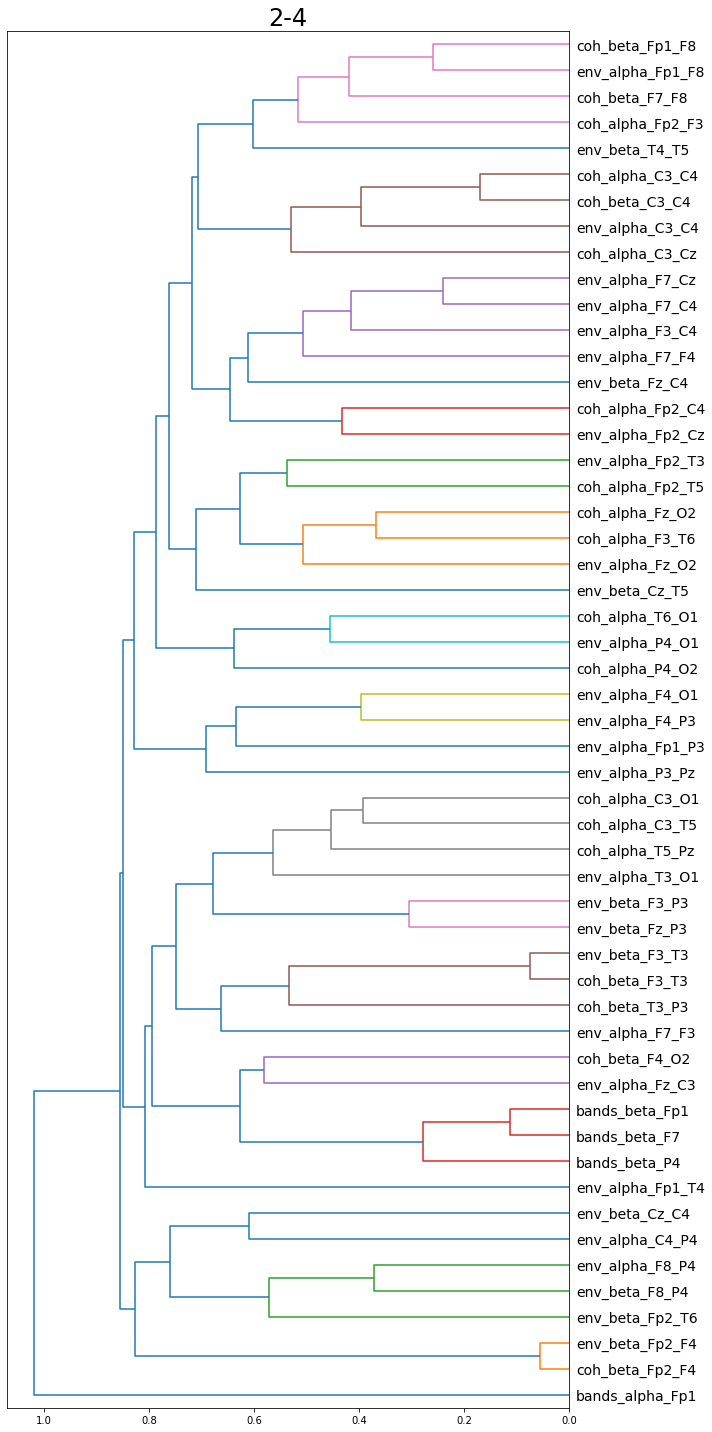

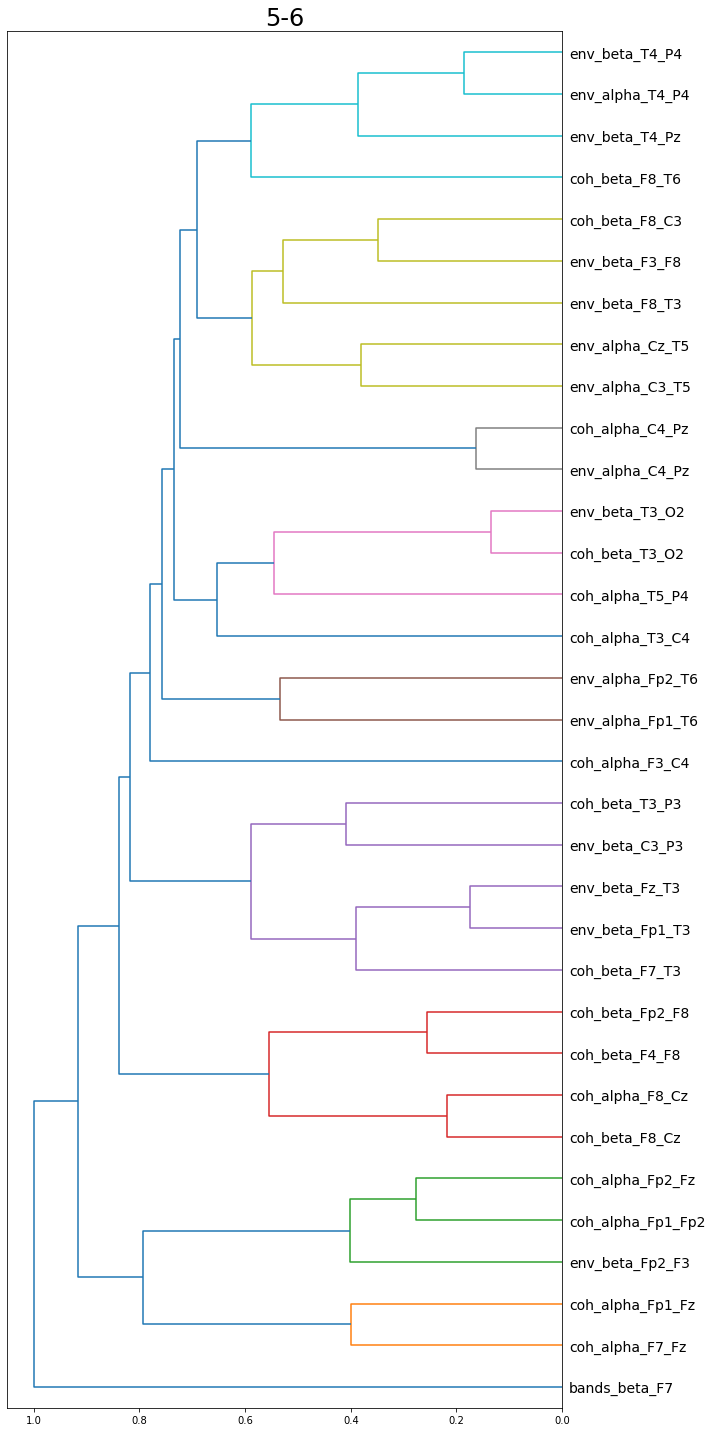

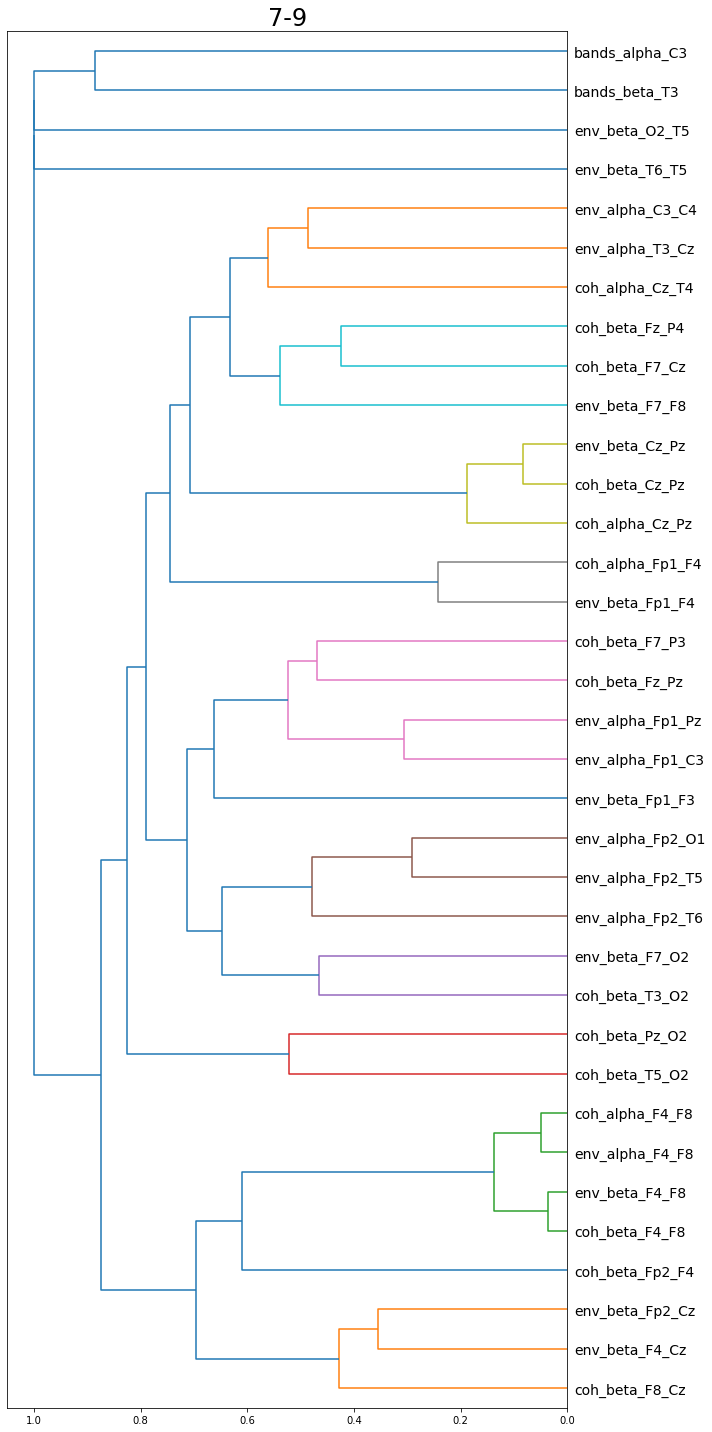

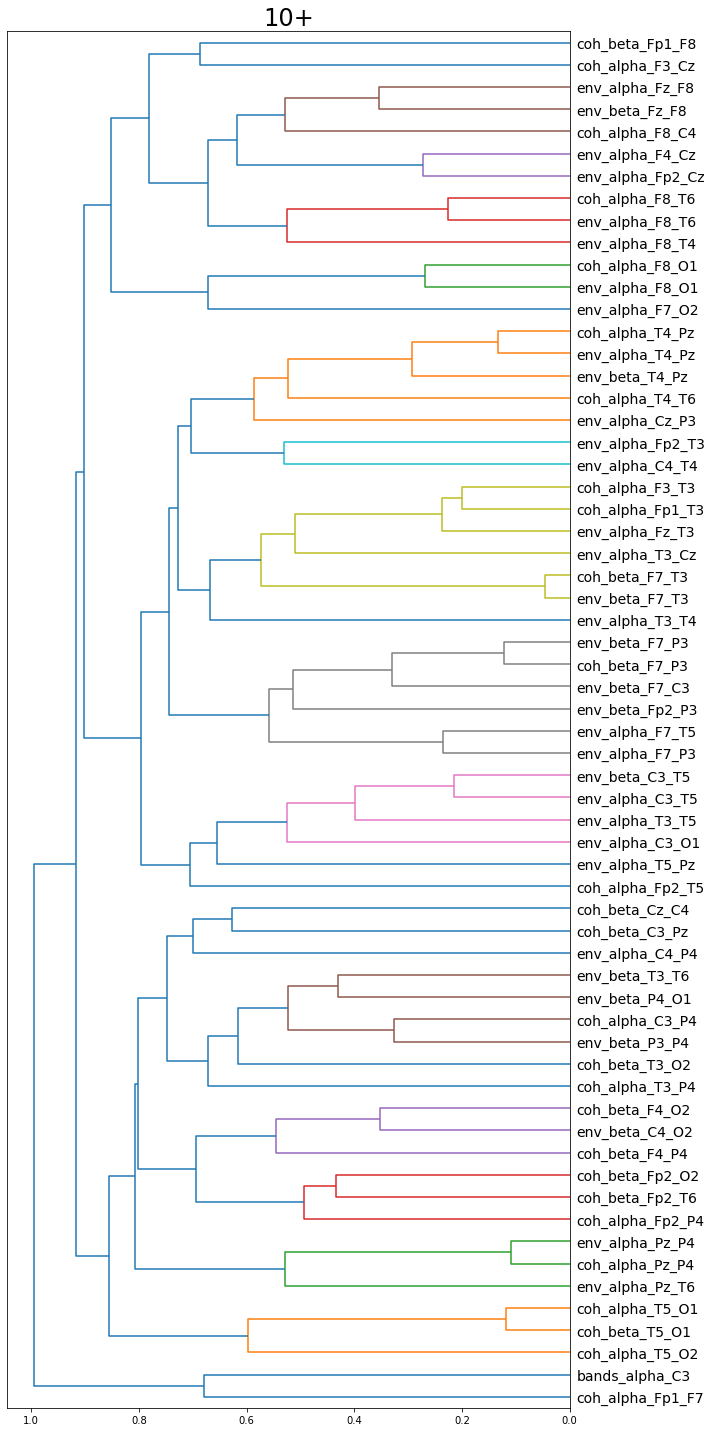

In [135]:
for ag_name in age_groups:
    plot_dendrogram(ag_name)
    plt.title(ag_name, fontsize=24)
    plt.tight_layout()
    plt.savefig(f'../images/asd/dendrograms/{ag_name}.pdf')

## Dendrogram of top features

In [10]:
ag_name = '10+'
ag = age_groups[ag_name]
df = data[data['age'].isin(ag)]
rows = []

for feature in features:
    score = roc_auc_score(df['target'], df[feature].fillna(0))
    rows.append(max(score, 1 - score))

performance = pd.Series(rows, index=features, name='roc_auc')
performance.sort_values(ascending=False, inplace=True)


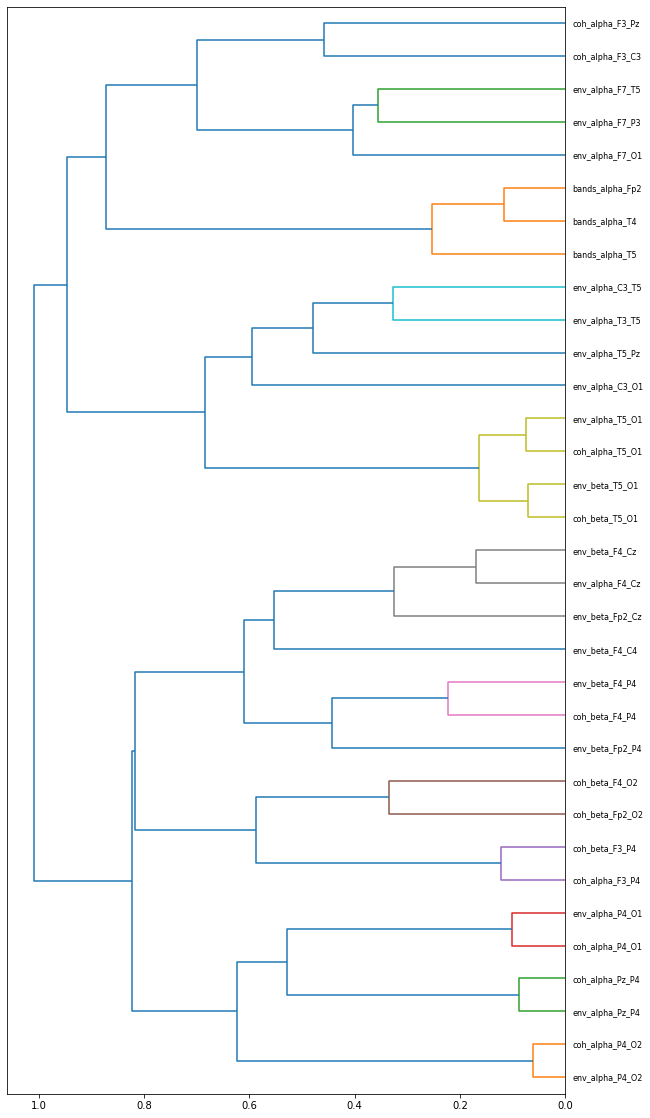

In [107]:
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage, dendrogram

top_features = performance[performance > 0.65].index

X = df[top_features]
dist_vector = squareform(1 - X.corr())
l_aver = linkage(dist_vector, method='average')

plt.figure(figsize=(10, 20))
dendrogram(l_aver, labels=top_features, orientation='left', color_threshold=0.4)
plt.show()

## Fearure importance

In [10]:
from pipeline import models
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

classifiers = {'LR': models.LRScaled(), 'SVM': models.SVMScaled(),
               'XGB': XGBClassifier(max_depth=4, n_estimators=30, n_jobs=-1, objective='binary:logistic',use_label_encoder=False, eval_metric='error'),
               'RF': RandomForestClassifier(n_estimators=30, max_depth=2, n_jobs=-1)}

In [92]:
def get_feature_scores(clf, model_name):
    if model_name == 'LR':
        coefs = abs(clf.lr.coef_).ravel()
        return coefs / coefs.sum()
    if model_name == 'SVM':
        coefs = abs(clf.model.coef_).ravel()
        return coefs / coefs.sum()
    return clf.feature_importances_

In [97]:
def get_feature_importances(ag_name, n_repeats=20):
    model_name = best_models[ag_name][1]
    features = best_features[ag_name, model_name]
    feat_imp = pd.Series(0, index=np.unique(flatten(features)))
    for _ in range(n_repeats):
        for fold in features:
            X = data.loc[data['age'].isin(age_groups[ag_name]), fold].fillna(0)
            y = data.loc[data['age'].isin(age_groups[ag_name]), 'target']
            clf = classifiers[model_name].fit(X, y)
            feat_imp[fold] += get_feature_scores(clf, model_name)
    return feat_imp / feat_imp.sum()

In [94]:
from scipy.special import softmax
f = best_features['2-4', 'LR']
feat_imp = pd.Series(0, index=np.unique(flatten(f)))
for fl in f:
    X = data.loc[data['age'].isin(range(2, 5)), fl].fillna(0)
    y = data.loc[data['age'].isin(range(2, 5)), 'target']
    clf = classifiers['RF'].fit(X, y)
    feat_imp[fl] += clf.feature_importances_

In [98]:
get_feature_importances('2-4').round(3).sort_values(ascending=False)

bands_beta_F7       0.097
coh_alpha_Fp2_T5    0.092
coh_alpha_P4_O2     0.070
coh_beta_Fp1_F8     0.058
coh_beta_F7_F8      0.058
env_alpha_C3_C4     0.056
coh_alpha_C3_T5     0.045
coh_beta_T3_P3      0.042
env_alpha_F7_C4     0.040
env_alpha_F7_F4     0.038
env_beta_Fp2_T6     0.032
env_alpha_F4_O1     0.026
bands_alpha_Fp1     0.023
coh_alpha_Fp2_F3    0.022
coh_alpha_T6_O1     0.019
coh_alpha_C3_C4     0.019
env_alpha_F7_Cz     0.017
coh_beta_Fp2_F4     0.016
env_beta_F3_T3      0.016
env_alpha_Fp1_P3    0.016
env_alpha_Fp1_F8    0.015
bands_beta_Fp1      0.012
env_beta_Cz_C4      0.012
env_alpha_P4_O1     0.011
env_alpha_F4_P3     0.011
env_alpha_F8_P4     0.010
env_alpha_F3_C4     0.010
env_beta_Fp2_F4     0.009
coh_beta_F3_T3      0.009
env_alpha_F7_F3     0.009
env_beta_F3_P3      0.009
env_alpha_Fz_O2     0.008
env_beta_F8_P4      0.007
coh_alpha_Fz_O2     0.007
env_alpha_C4_P4     0.006
env_alpha_Fp2_T3    0.006
coh_beta_F4_O2      0.006
env_alpha_Fp2_Cz    0.005
env_beta_Fz_

In [31]:
from sklearn.model_selection import StratifiedKFold

def kfold(X, y, clf, k=5):
    cv = StratifiedKFold(5)
    y_true, y_scores = [], []
    for train_ix, test_ix in cv.split(X, y):
        clf.fit(X[train_ix], y[train_ix])
        y_true.append(y[test_ix])
        y_scores.append(clf.predict_proba(X[test_ix])[:, 1])

    return y_true, y_scores

def repeated_kfold(X, y, clf, k=5, n_repeats=10):
    cv = StratifiedKFold(5)
    y_true, y_scores = [], []
    for _ in range(n_repeats):
        for train_ix, test_ix in cv.split(X, y):
            clf.fit(X[train_ix], y[train_ix])
            y_true.append(y[test_ix])
            y_scores.append(clf.predict_proba(X[test_ix])[:, 1])

    return y_true, y_scores

In [99]:
feature_thresholds = {'2-4': 0.06, '5-6': 0.08, '7-9': 0.1}
final_results = {}

for ag_name, threshold in feature_thresholds.items():
    feature_scores = get_feature_importances(ag_name)
    features_final = feature_scores[feature_scores > threshold].index
    print(ag_name, features_final)
    X = data.loc[data['age'].isin(age_groups[ag_name]), features_final].fillna(0).reset_index(drop=True)
    y = data.loc[data['age'].isin(age_groups[ag_name]), 'target'].reset_index(drop=True)

    final_results[ag_name] = repeated_kfold(X.values, y, classifiers[best_models[ag_name][1]])


2-4 Index(['bands_beta_F7', 'coh_alpha_Fp2_T5', 'coh_alpha_P4_O2'], dtype='object')
5-6 Index(['coh_alpha_C4_Pz', 'env_beta_Fp1_T3', 'env_beta_T4_P4'], dtype='object')
7-9 Index(['bands_alpha_C3', 'coh_beta_F4_F8', 'env_beta_F4_F8'], dtype='object')


In [34]:
features_manual = ['bands_beta_F7', 'coh_alpha_Fp2_T5', 'coh_alpha_P4_O2']

from sklearn.model_selection import StratifiedKFold
X = data.loc[data['age'].isin(age_groups['2-4']), features_manual].fillna(0).reset_index(drop=True).values
y = data.loc[data['age'].isin(age_groups['2-4']), 'target'].reset_index(drop=True)

In [86]:
from sklearn.metrics import roc_auc_score, accuracy_score

def get_scores(true, preds):
    roc_aucs = [roc_auc_score(t, p) for t, p in zip(true, preds)]
    accs = [accuracy_score(t, p > 0.5) for t, p in zip(true, preds)]
    return np.round([np.mean(roc_aucs), np.std(roc_aucs), np.mean(accs), np.std(accs)], 3)

In [100]:
for ag_name, res in final_results.items():
    print(ag_name, get_scores(*res))

2-4 [0.776 0.155 0.758 0.121]
5-6 [0.869 0.118 0.857 0.108]
7-9 [0.773 0.067 0.712 0.053]


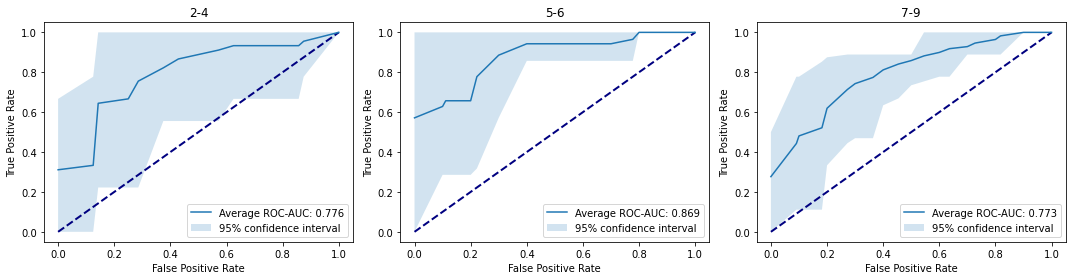

In [101]:
import sys
sys.path.append('../../snippets/')
from vis import plot_roc_curve_ci_wrong

i = 0
fig = plt.figure(figsize=(15, 4))
for ag_name, result in final_results.items():
    i += 1
    ax = plt.subplot(1, 3, i)
    ax.set_title(ag_name)
    plot_roc_curve_ci_wrong(*result, ax=ax)

fig.tight_layout()
fig.savefig('../images/asd/roc-curves_final.png')

# Feature visualization

In [10]:
montage = mne.channels.make_standard_montage('standard_1020')

info = mne.io.meas_info.create_info(montage.ch_names, sfreq=256, ch_types="eeg")
mne.io.RawArray(np.zeros((len(montage.ch_names), 1)), info, copy=None).set_montage(montage)
channels_to_use_ = [ch for ch in info.ch_names if ch in ch_names]
info.pick_channels(channels_to_use_);
_, pos, _, ch_names, _, _, _ = mne.viz.topomap._prepare_topomap_plot(info, 'eeg');
pos = pd.DataFrame(pos, columns=['x', 'y'], index=ch_names)

Creating RawArray with float64 data, n_channels=94, n_times=1
    Range : 0 ... 0 =      0.000 ...     0.000 secs
Ready.


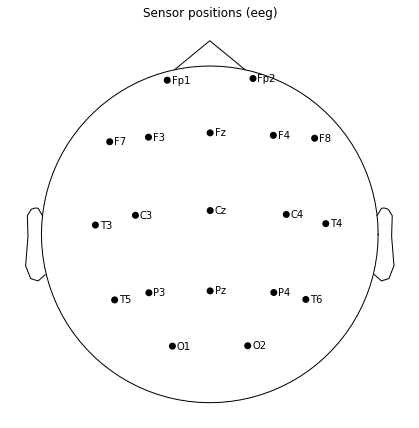

In [11]:
mne.viz.utils.plot_sensors(info, show_names=True, show=False)
plt.tight_layout()

In [12]:
from itertools import product
feature_types = list(map('_'.join, product(('coh', 'env', 'bands'), ('alpha', 'beta'))))

def parse_features(features):
    result = {k: [] for k in feature_types}
    for feature in features:
        split = feature.split('_')
        result['_'.join(split[:2])].append(split[2:])
    return result

def parse_feature_counts(features):
    result = {k: {} for k in feature_types}
    for feature, count in features.items():
        split = feature.split('_')
        result['_'.join(split[:2])][tuple(split[2:])] = count
    return result

In [13]:
def plot_features_type(channels, ax):
    if not channels:
        return
    dots = pos.loc[flatten(channels)]
    ax.scatter(*dots.values.T, s=300, alpha=0.5, c='orange')
    if len(channels[0]) == 2:
        for pair in channels:
            ax.plot(*pos.loc[pair].values.T, lw=2, c='orange')

def annotate_counts(channels, ax):
    for chans, count in channels.items():
        ax.annotate(count, pos.loc[list(chans)].mean(axis=0), fontsize=24)

In [14]:
def plot_features_fold(features, axes):
    for (type_, chans), ax in zip(parse_features(features).items(), axes):
        mne.viz.utils.plot_sensors(info, show_names=False, show=False, axes=ax)
        ax.set_title(type_, fontsize=30)
        plot_features_type(chans, ax)

def plot_featues_agg(features, axes):
    plot_features_fold(features, axes)
    for channels, ax in zip(parse_feature_counts(features).values(), axes):
        annotate_counts(channels, ax)

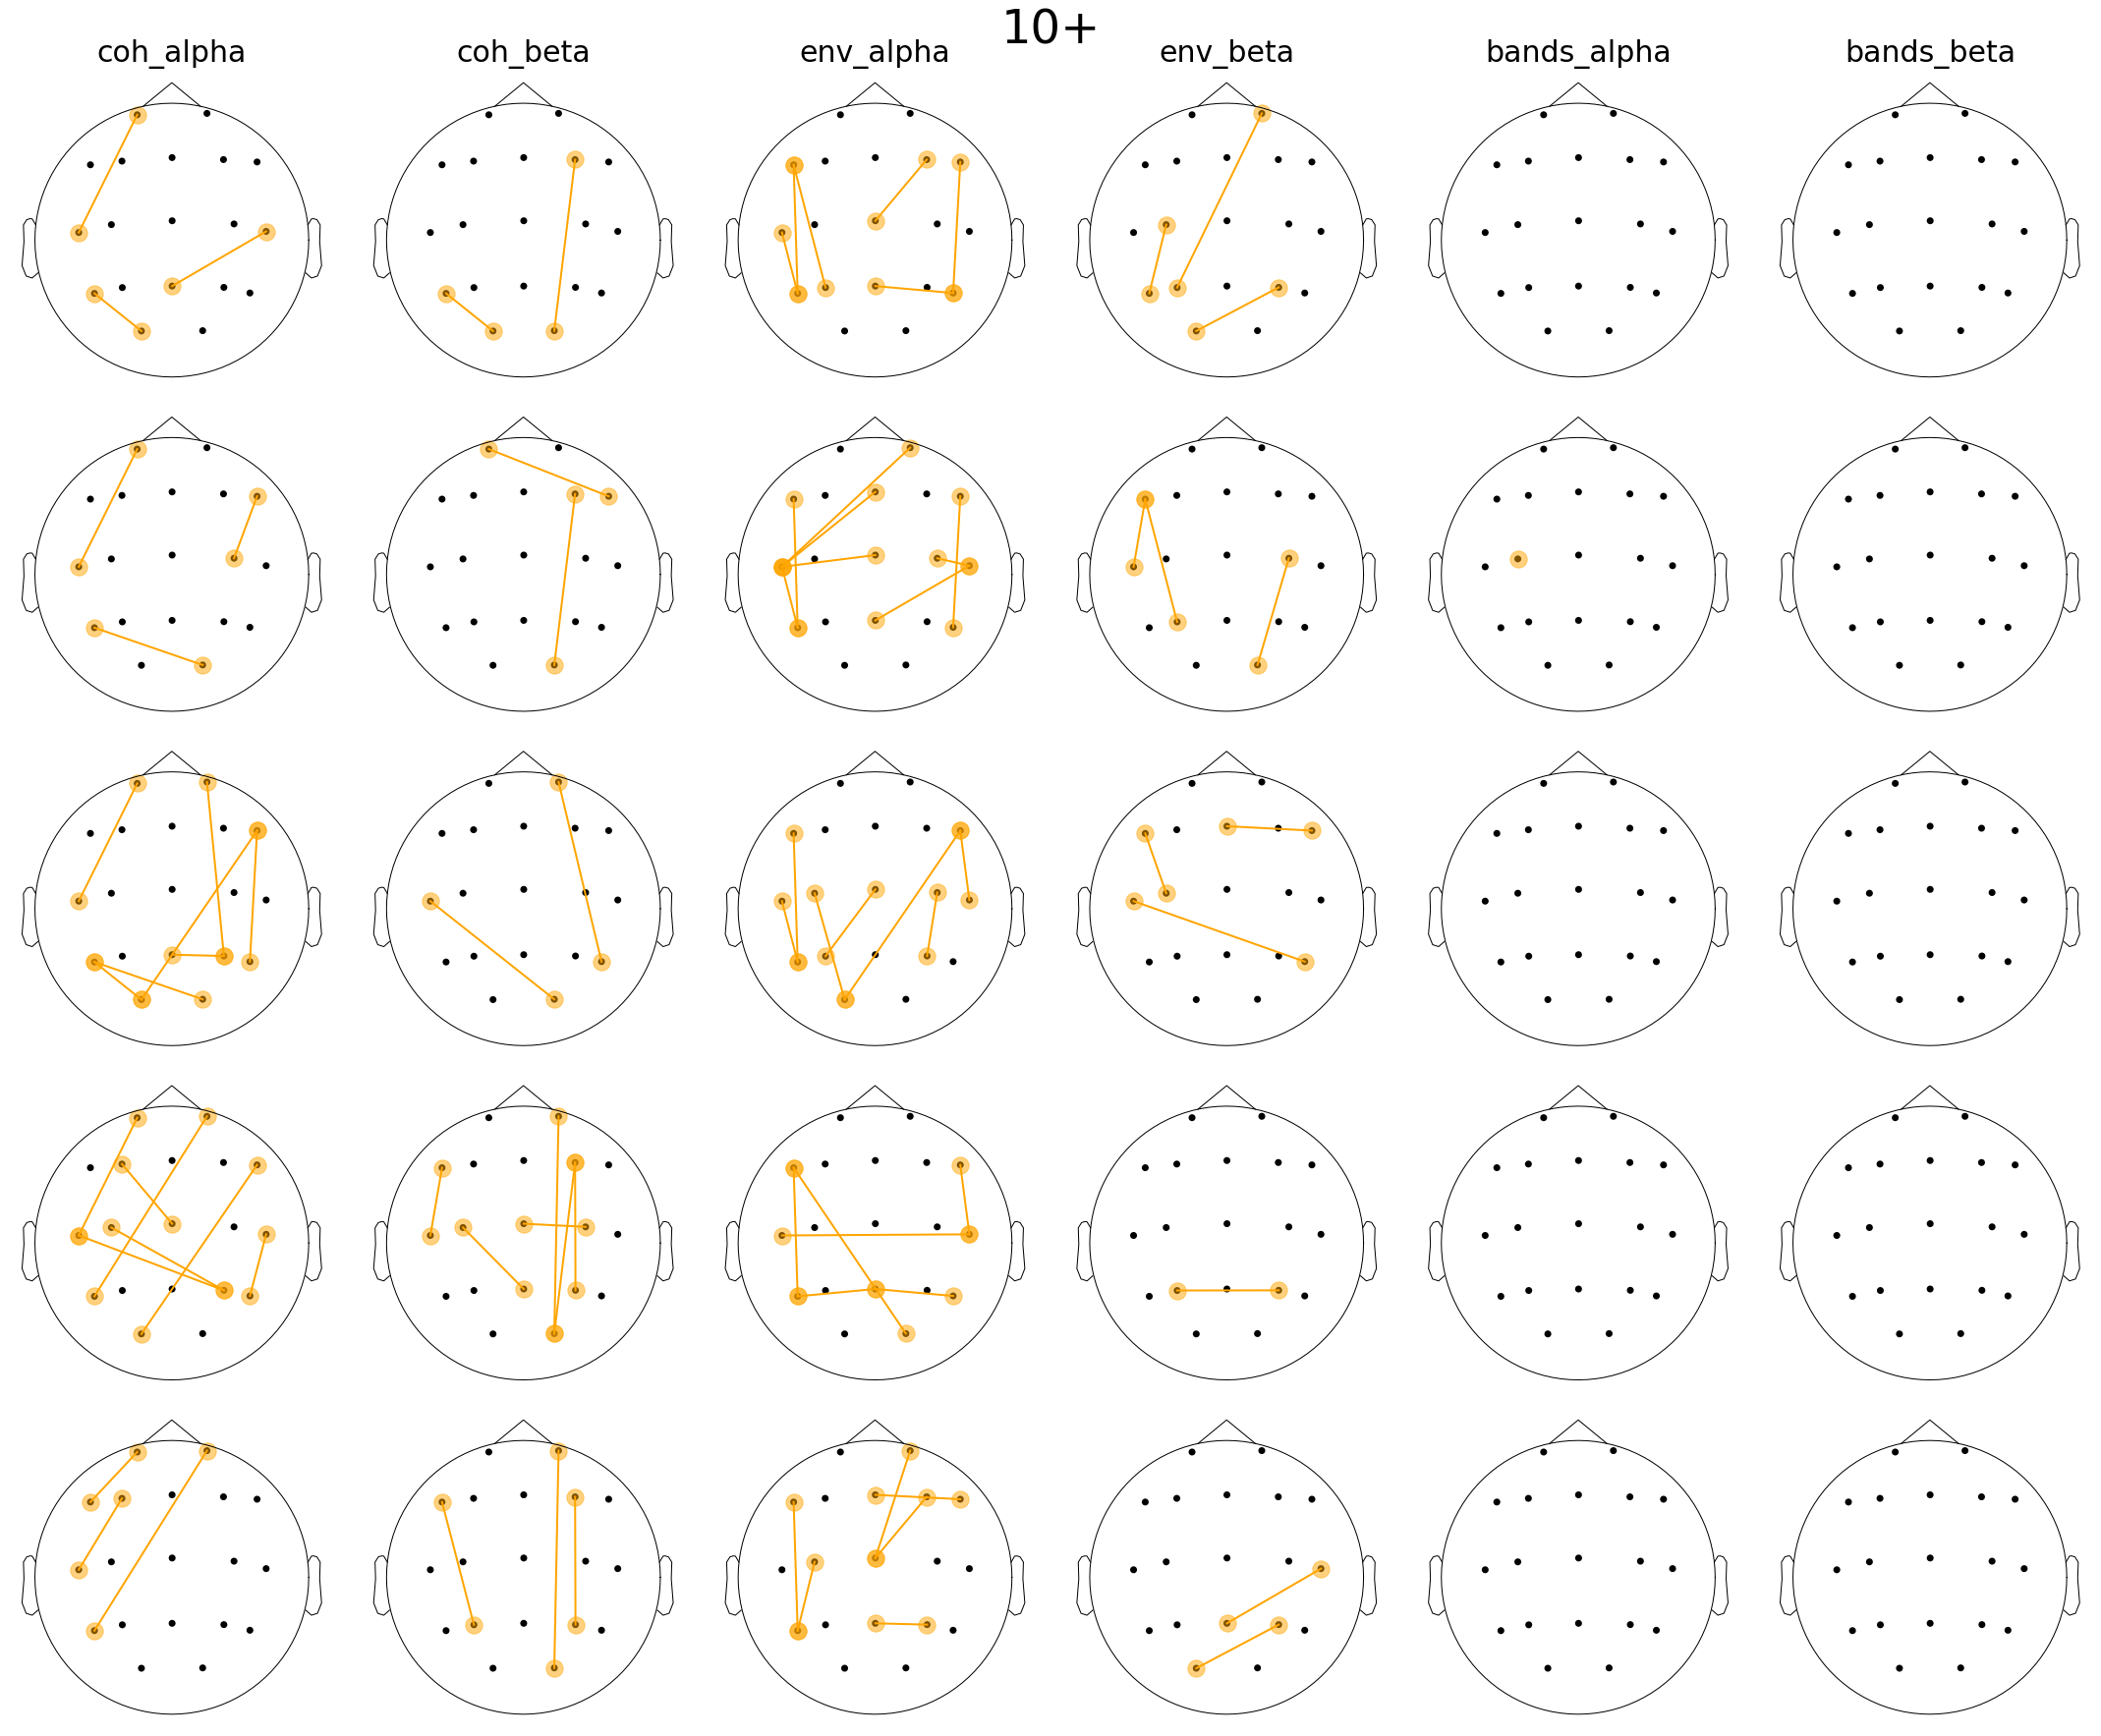

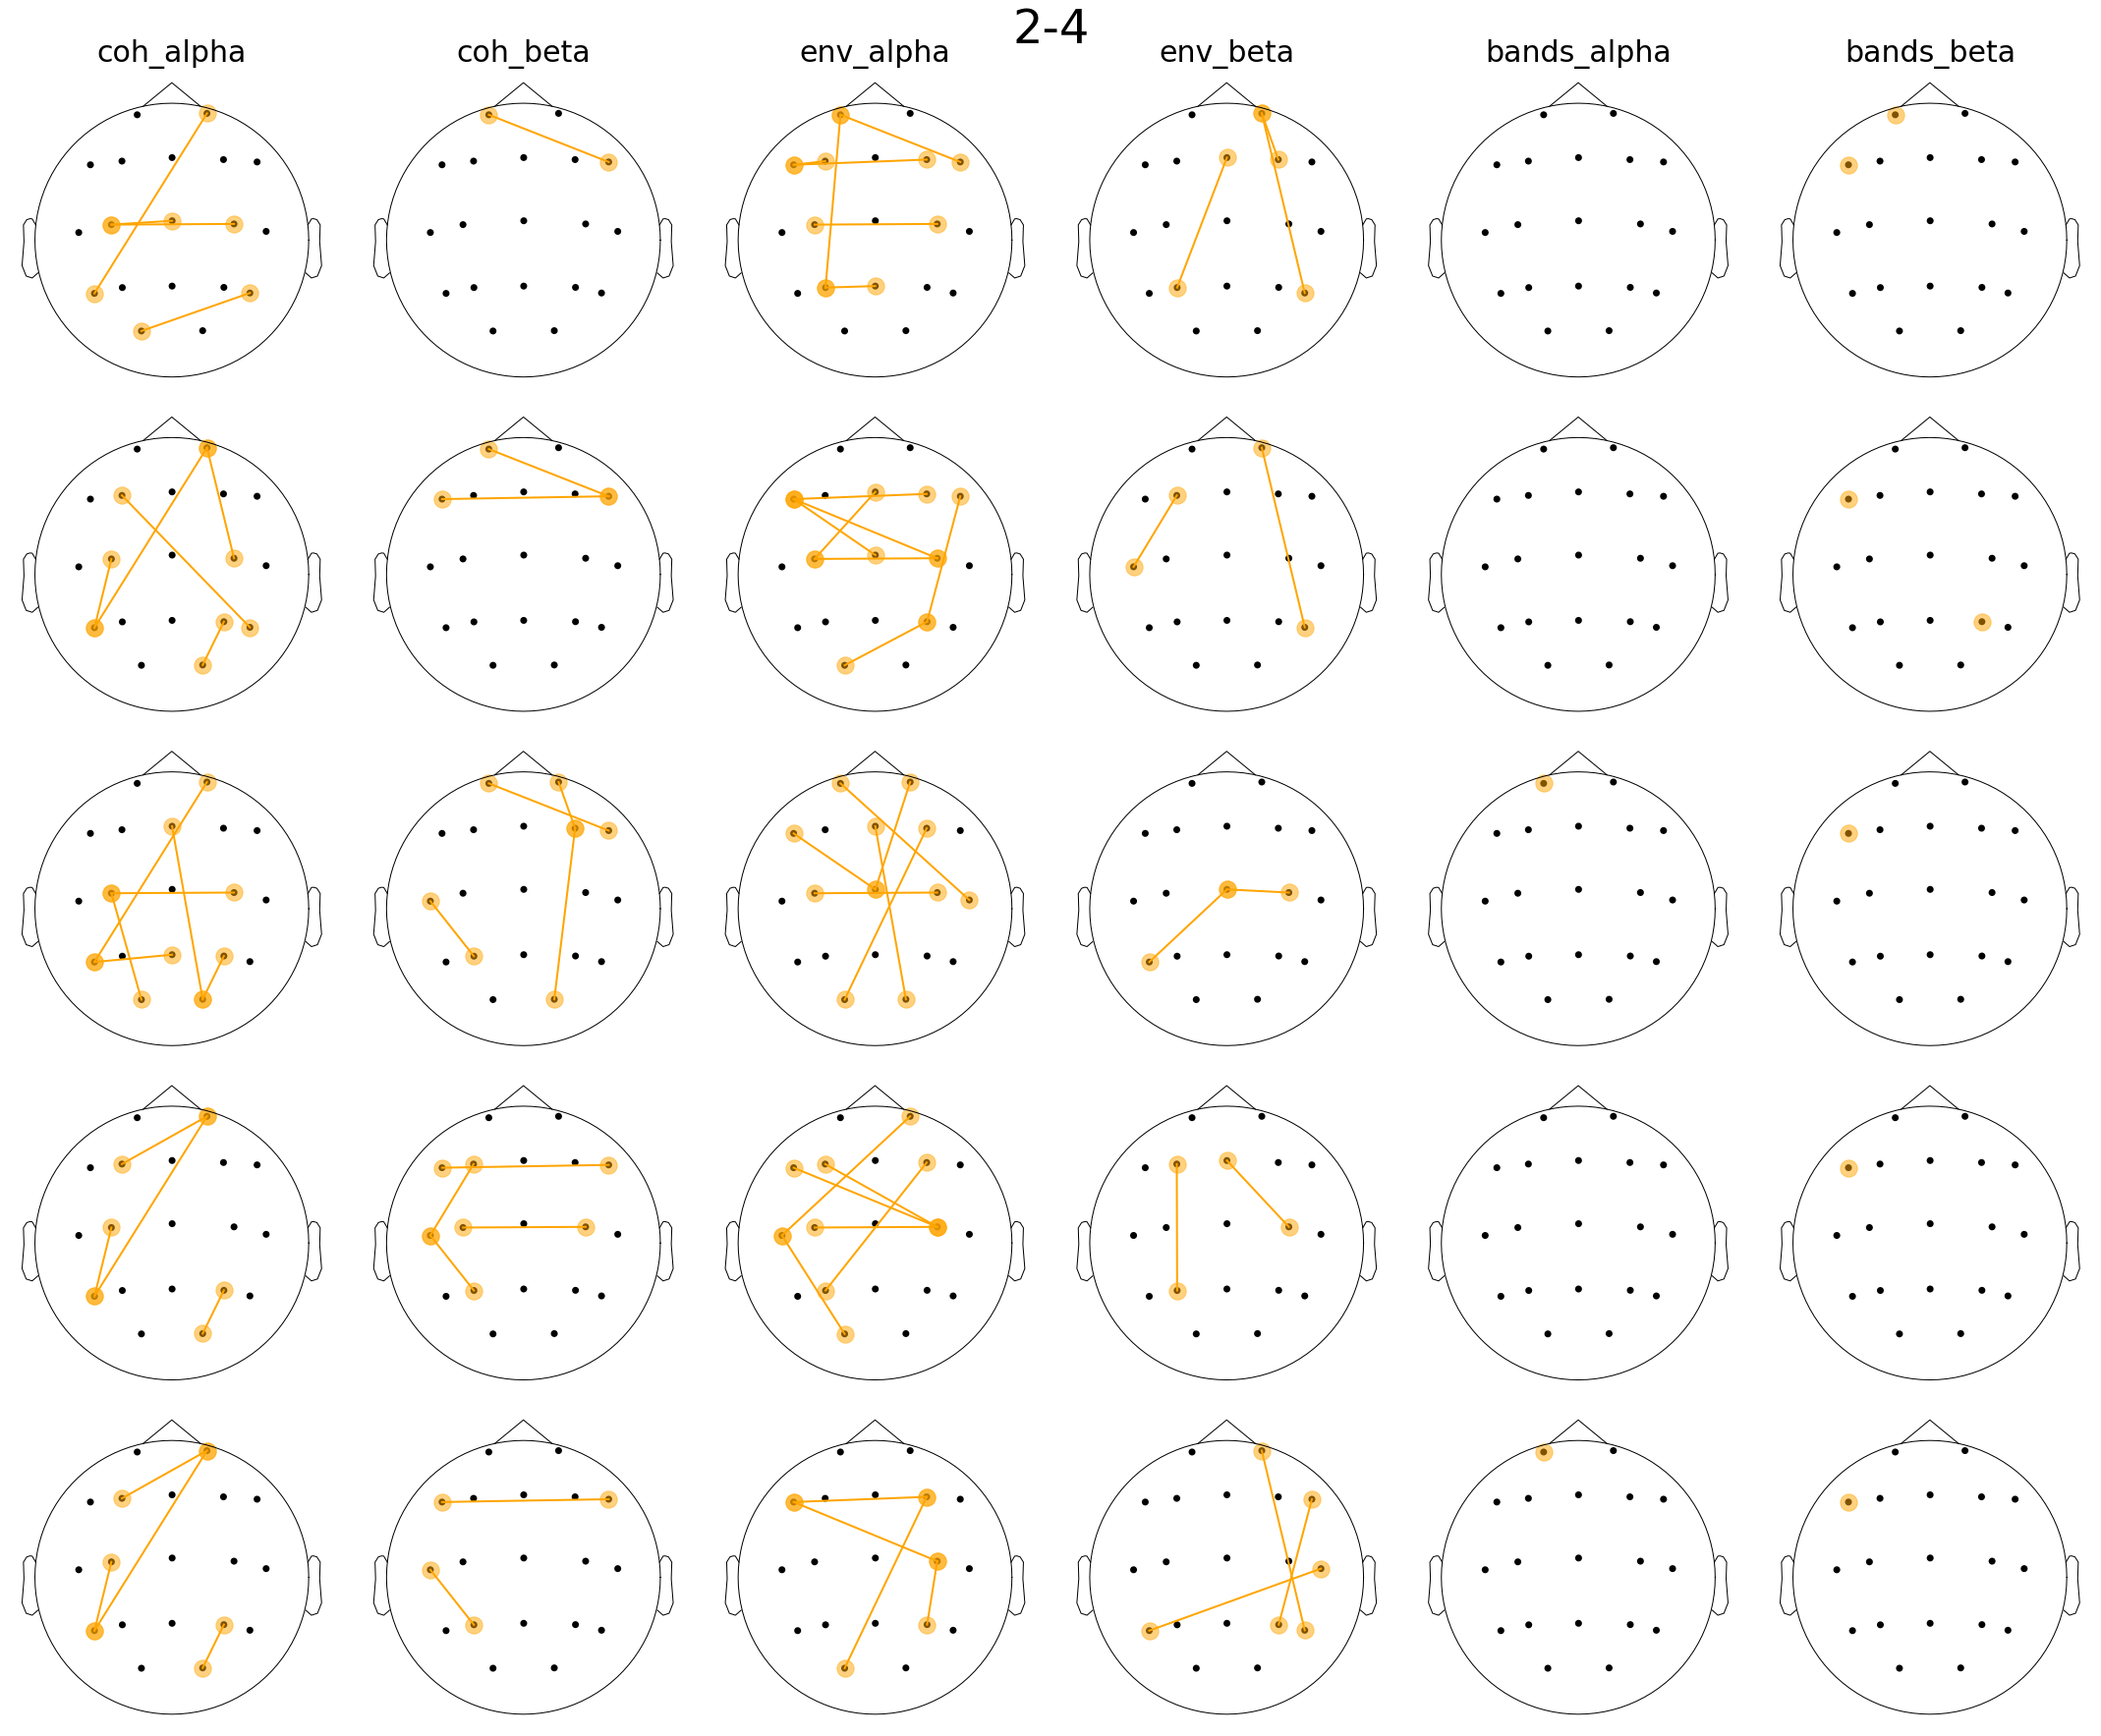

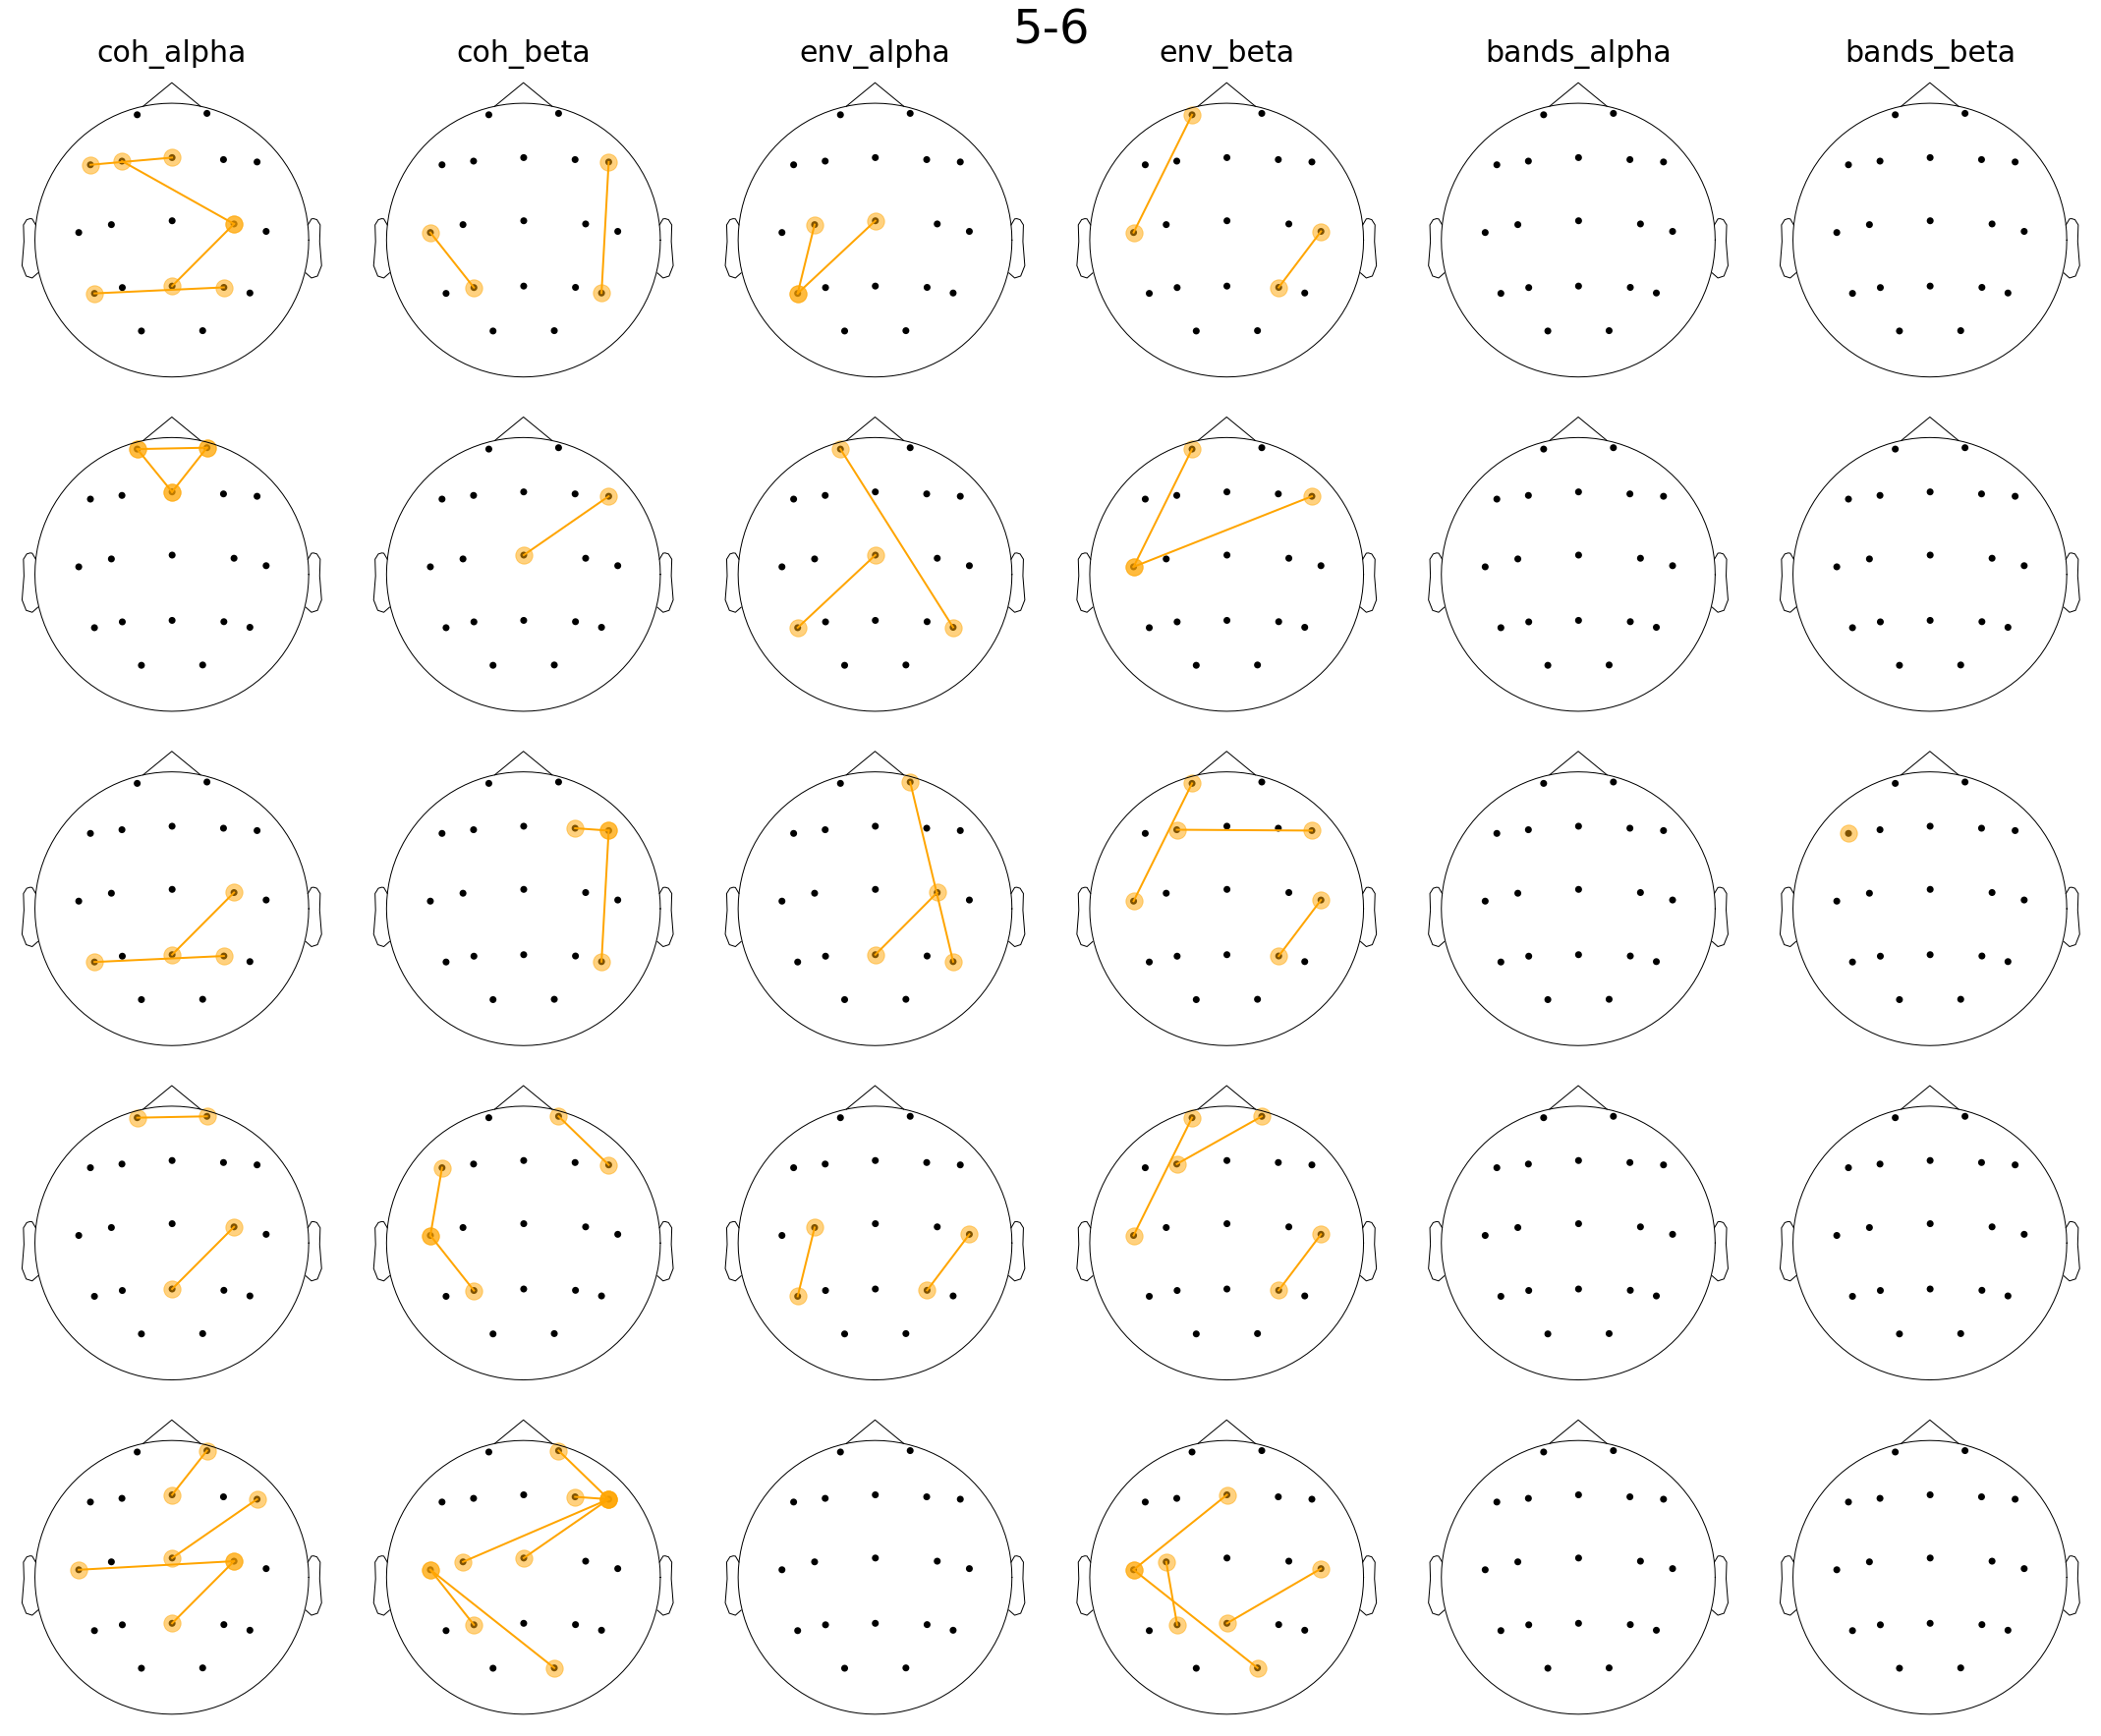

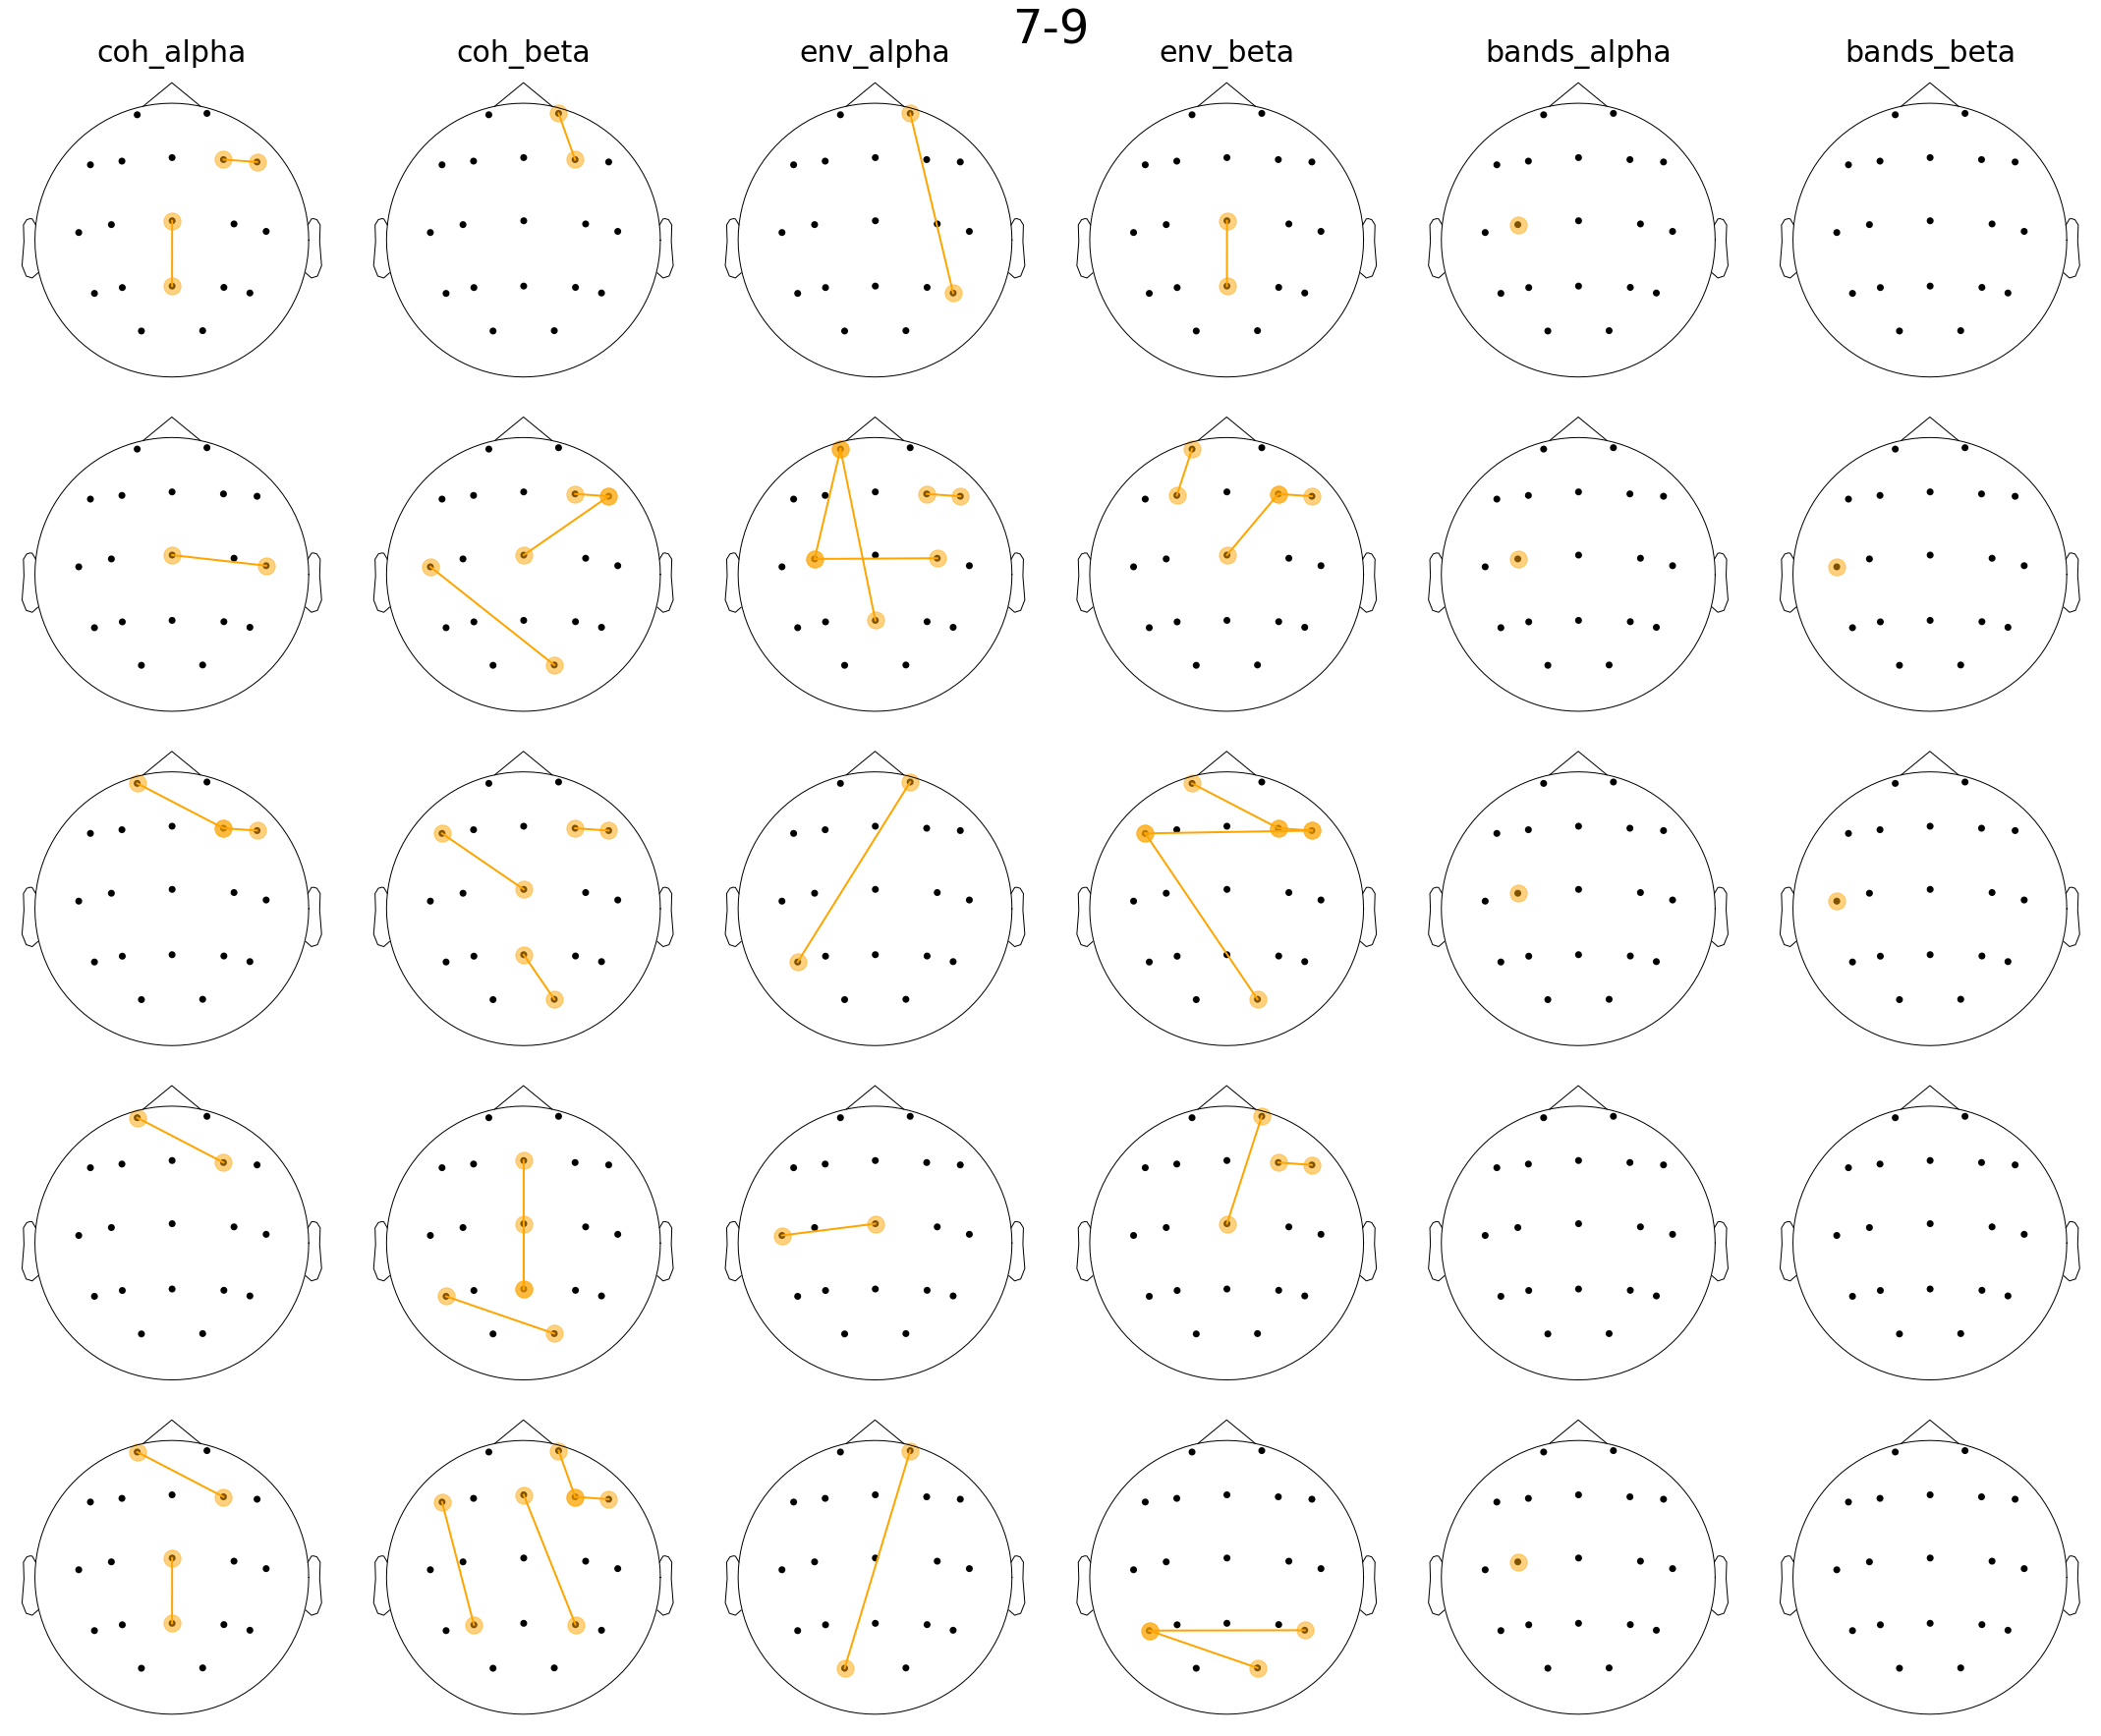

In [16]:
for label, feats in best_features.items():
    ag_name, model = label
    n_folds, n_cols = len(feats), 6
    fig, axes = plt.subplots(n_folds, n_cols, figsize=(5 * n_cols, 5 * n_folds))
    plt.subplots_adjust(wspace=0, hspace=0)
    for i, fold in enumerate(feats):
        plot_features_fold(fold, axes[i])

    for ax in flatten(axes[1:]):
        ax.set_title('')
    fig.suptitle(ag_name, fontsize=48)
    fig.tight_layout()
    plt.savefig(f'../images/asd/({ag_name})_fold.jpg')

In [32]:
from collections import Counter

def get_feature_counts(selected_features):
    return {key: Counter(flatten(features)) for key, features in best_features.items()}

counts = get_feature_counts(selected_features)

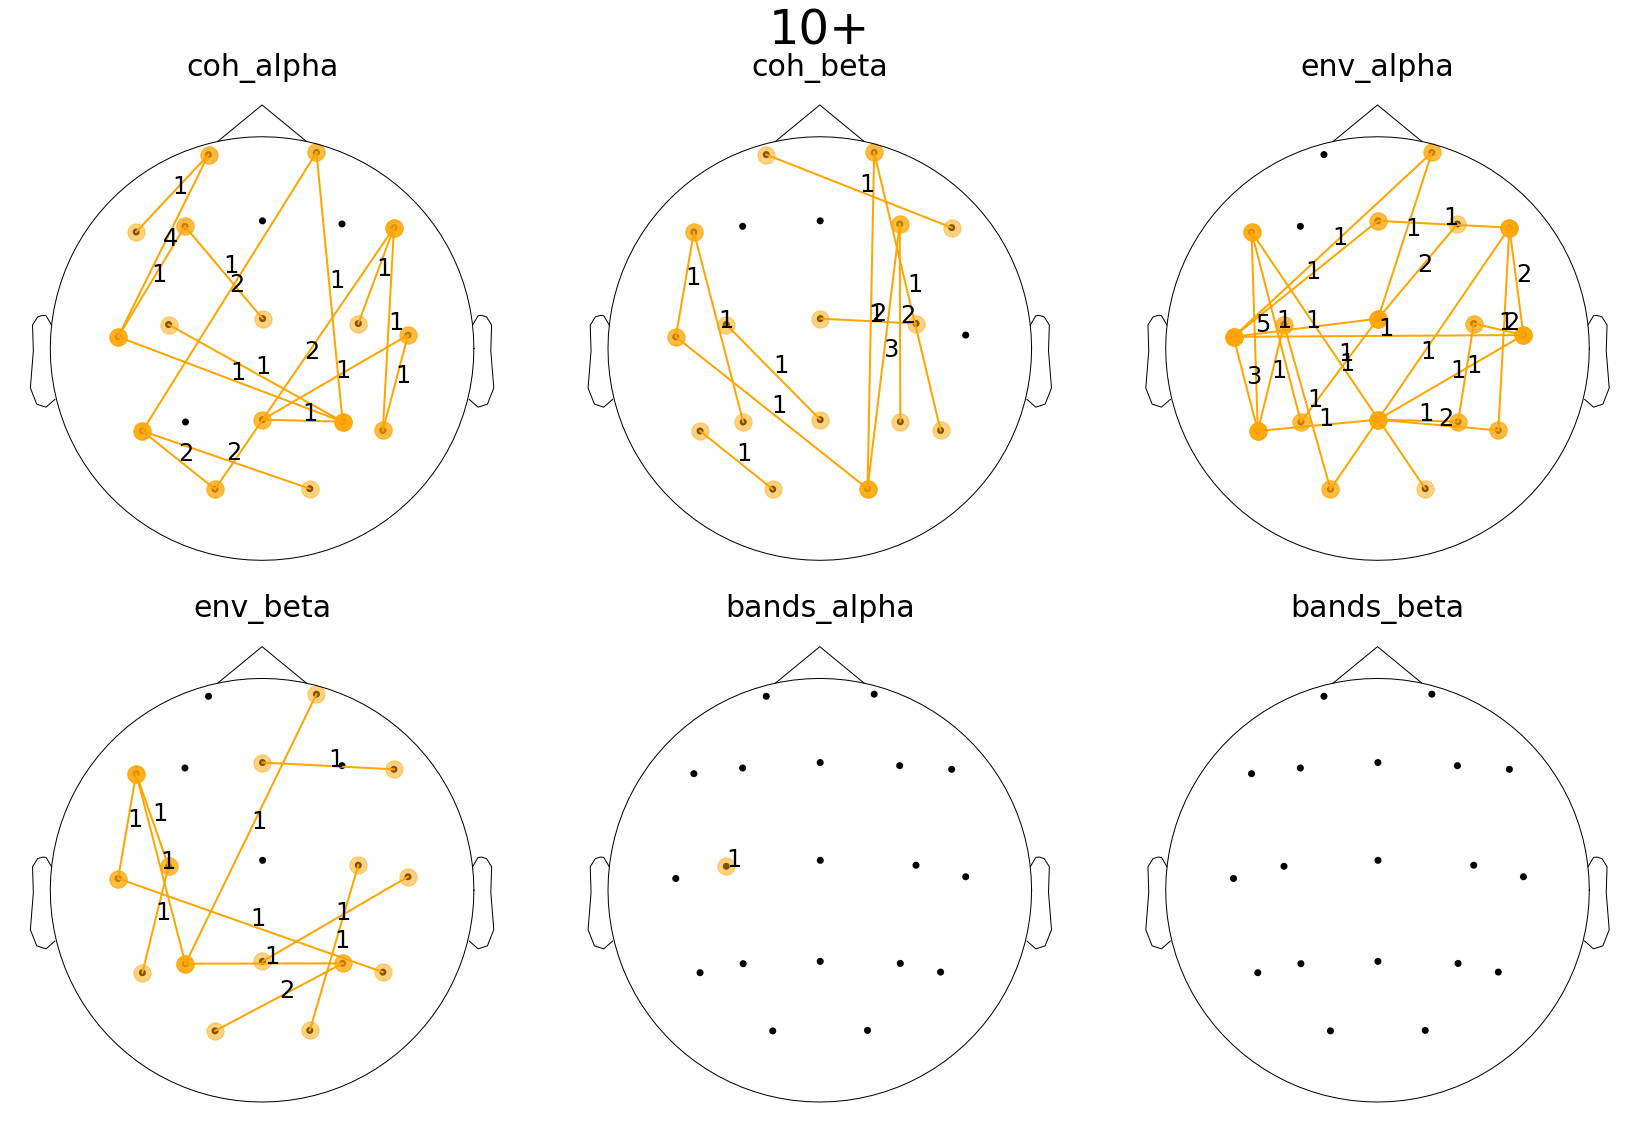

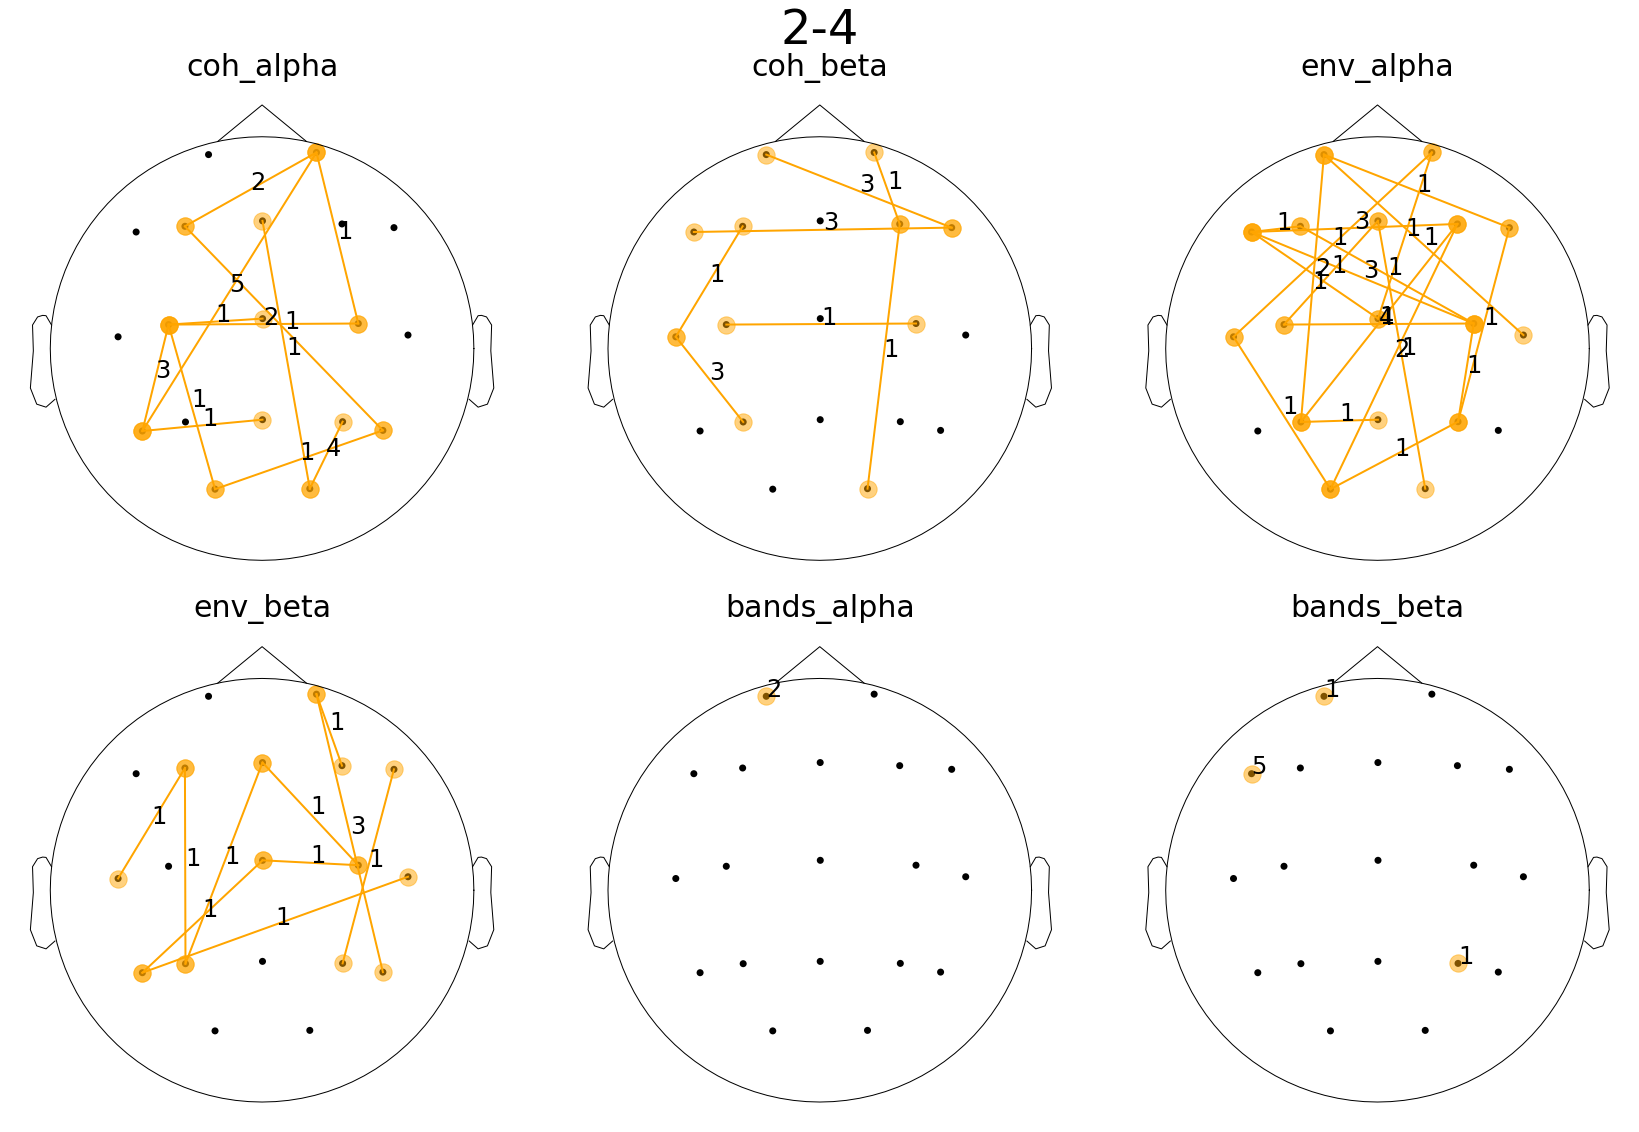

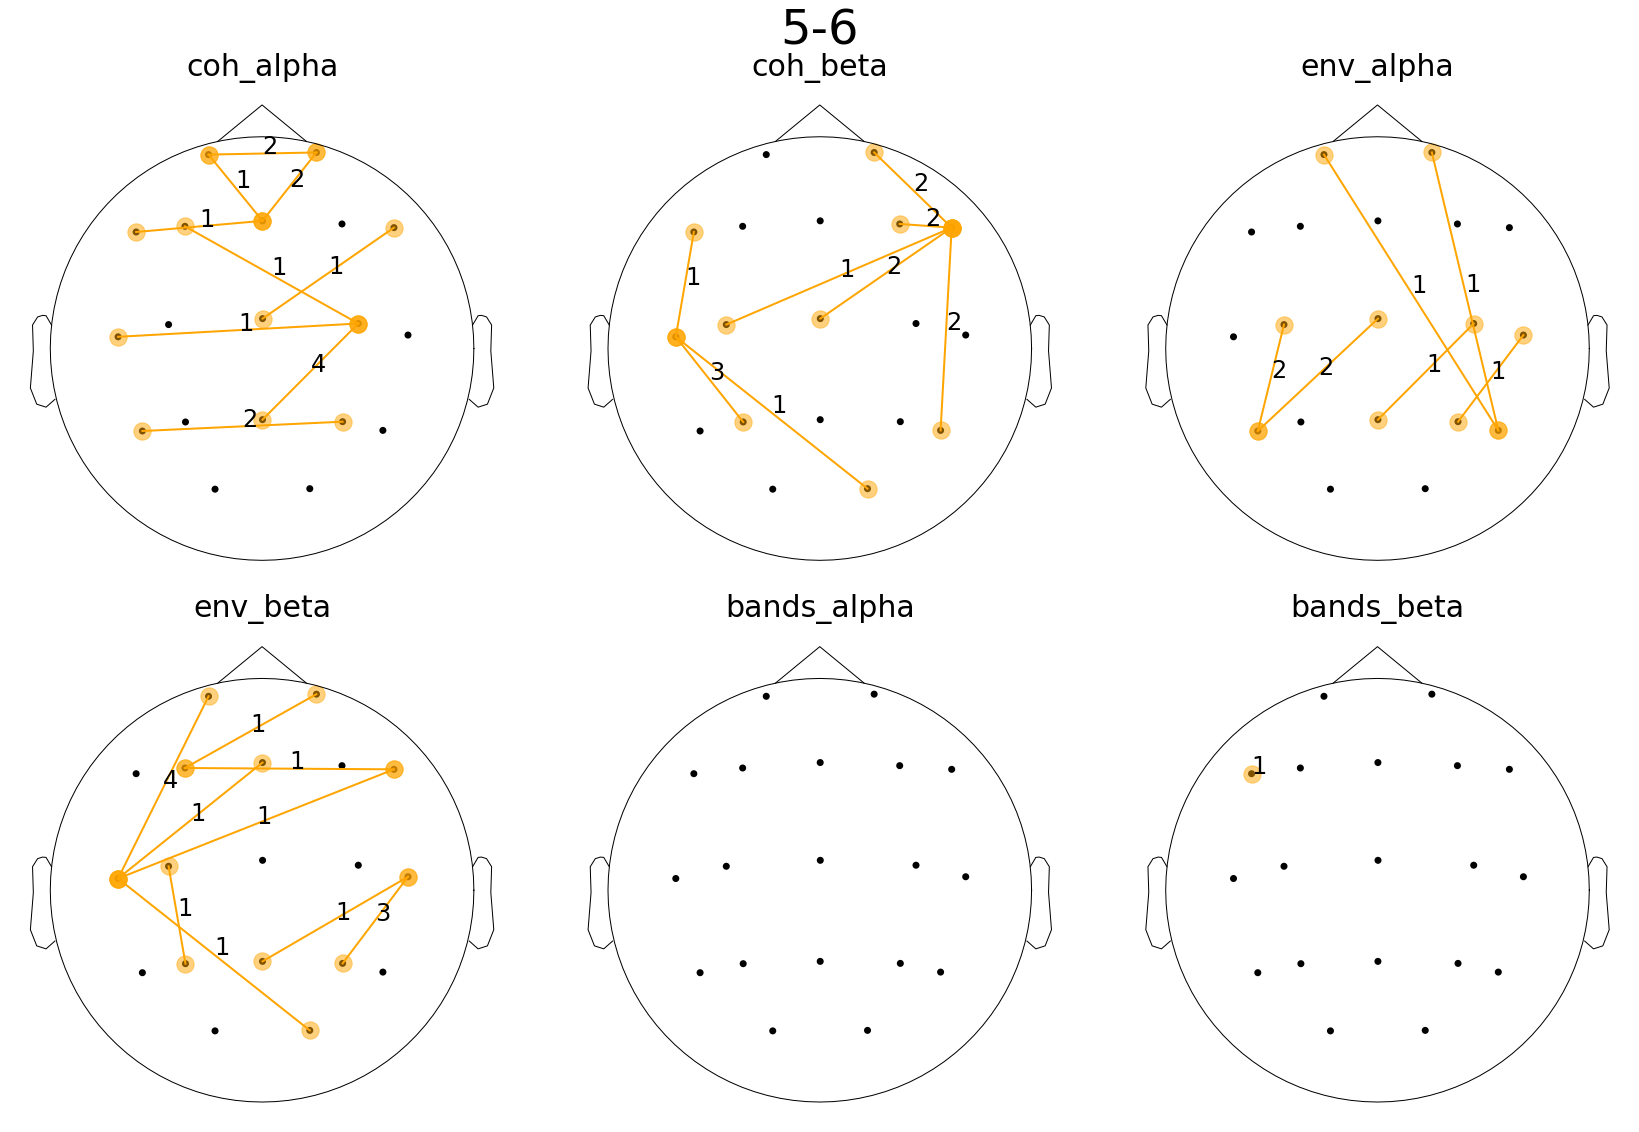

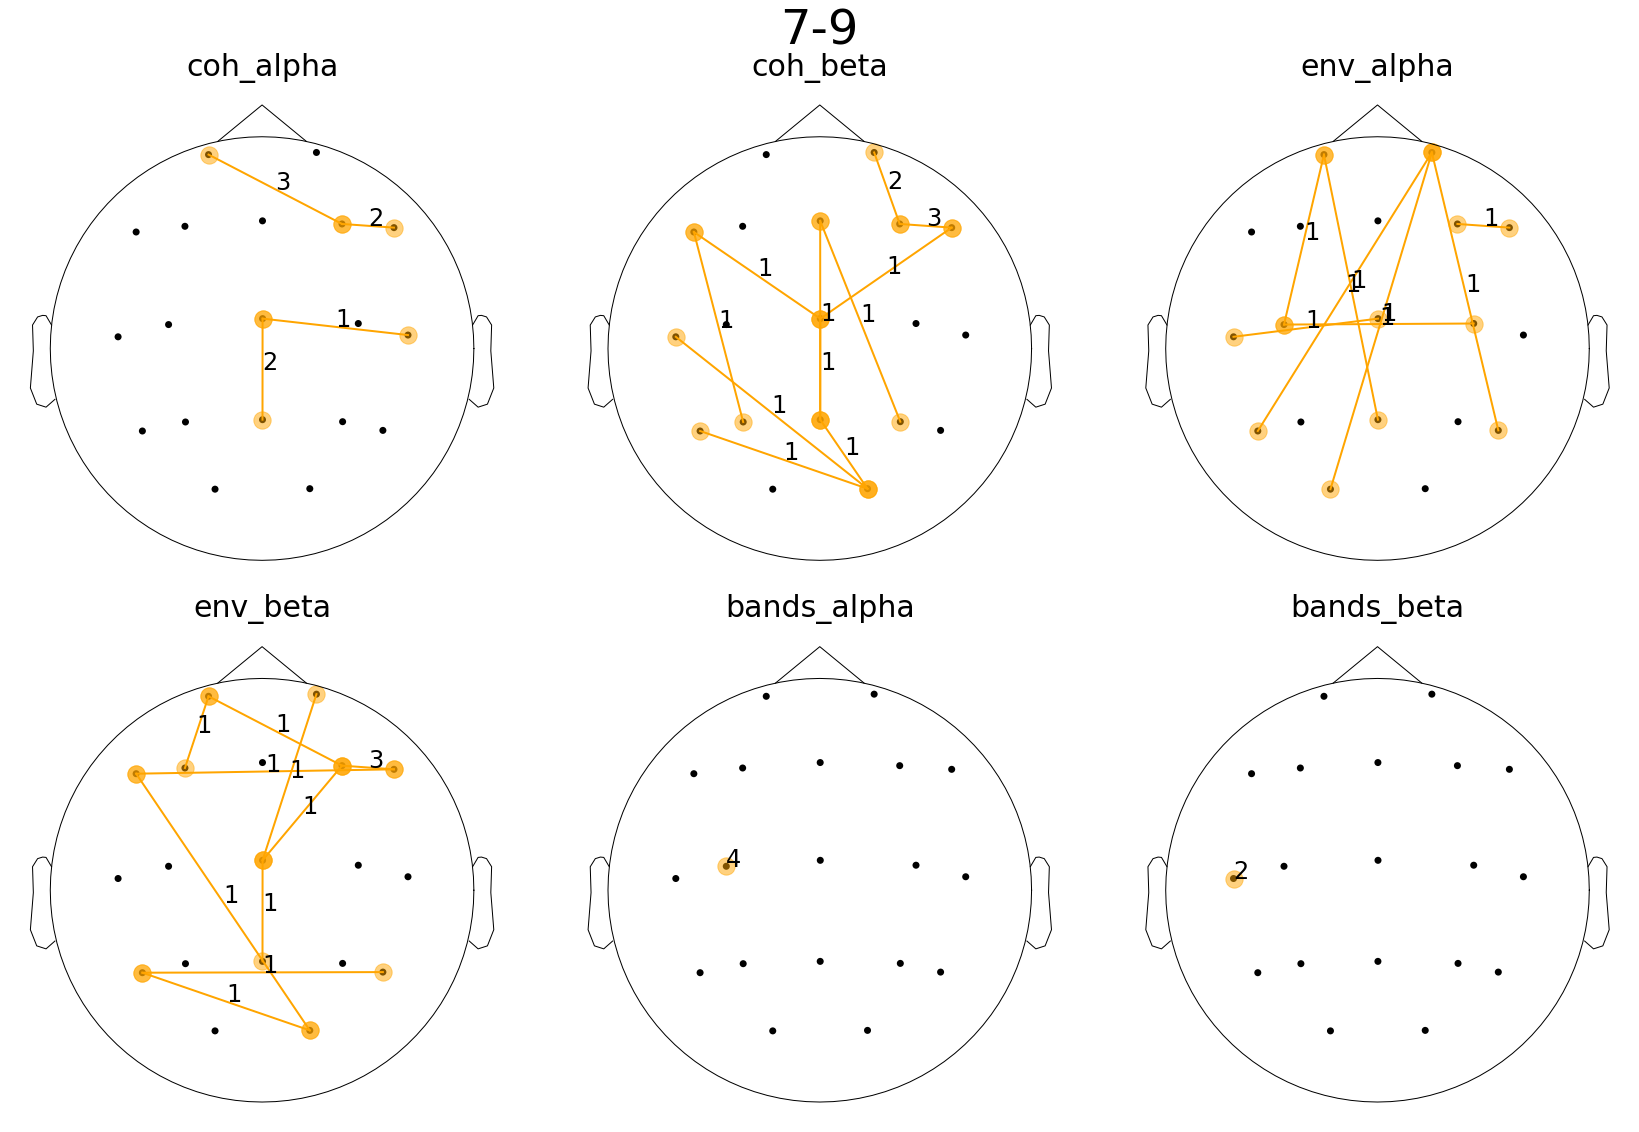

In [35]:
for ag_name, c in counts.items():
    fig, axes = plt.subplots(2, 3, figsize=[24, 16])
    plt.subplots_adjust(wspace=0)
    plot_featues_agg(c, flatten(axes))
    fig.suptitle(ag_name[0], fontsize=48)
    plt.tight_layout()
    plt.savefig(f'../images/asd/({ag_name[0]})_combined.jpg')

In [10]:
with open('scores.pickle', 'rb') as f:
    scores = pickle.load(f)

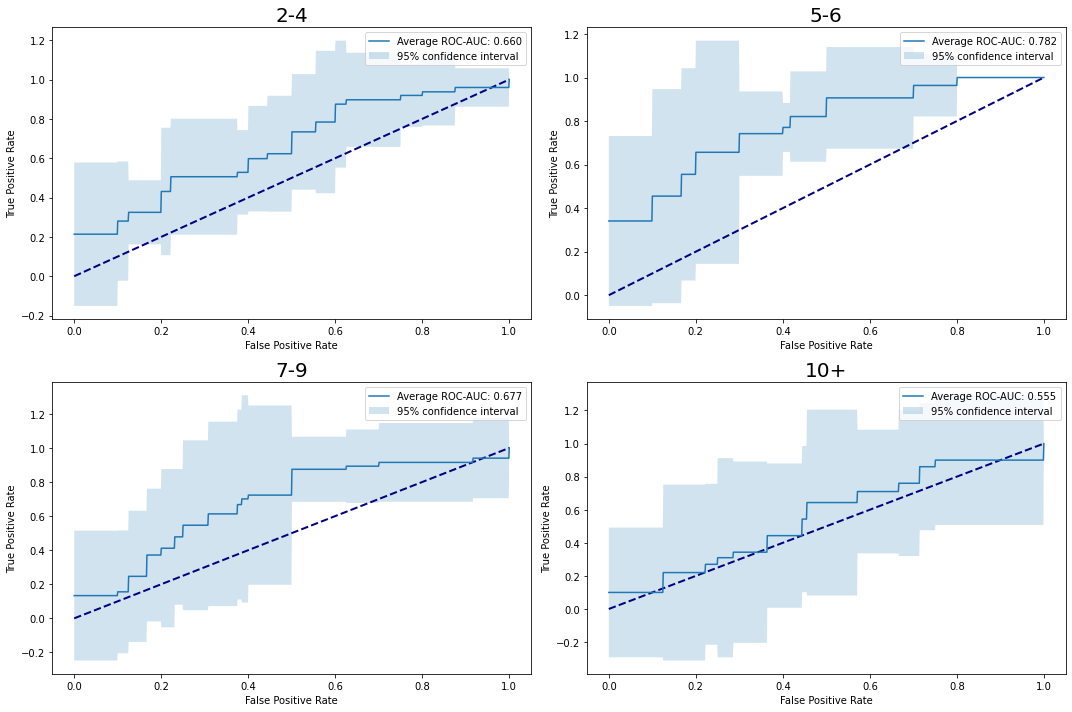

In [18]:
import sys
sys.path.append('../../snippets/')
from vis import plot_roc_curve_ci_wrong

i = 0
plt.figure(figsize=(15, 10))
for ag_name in age_groups:
    i += 1
    ax = plt.subplot(2, 2, i)
    ax.set_title(ag_name, fontsize=20)
    plot_roc_curve_ci_wrong(scores[best_models[ag_name]].y_true, scores[best_models[ag_name]].y_pred, ax=ax, method='normal')

plt.tight_layout()
# plt.savefig('../images/roc-curves-steps.png')